# 导入工具包

In [1]:
import matplotlib.ticker as ticker
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import gridspec
from matplotlib.colors import ListedColormap 
import matplotlib.cm as cm
import sys
import matplotlib.colors as mcolors
import pickle
import os
import glob
from datetime import datetime, timedelta
import cmaps
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cftime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker
import matplotlib.lines as mlines
from scipy import stats
from typing import Tuple, List, Optional
sys.path.append(r'K:\2024\2024-JGR-A-CMIP6_kelvin\CCKWs_ipynb_2025\cckw_tools')
from cckw_tools import plot_cckw_envelope, save_figure, get_curve,create_cmap_from_string
from cckw_tools import ma as mp
from cckw_tools import SpectrumPlotter
from cckw_tools import TaylorDiagram
from cckw_tools import Spectrum
from cckw_tools import plot_space_data

In [ ]:

# 调用画图函数
plot_cckw_envelope(he=[8, 12, 25, 50, 90], fmax=[1/3,  0.5],dpi=200)


## Fig.01. GPCP频谱图

In [ ]:



# 读取数据集
def read_data(file):
    return xr.open_dataset(file)


def custom_sort(file):
    if 'GPCP' in file:
        return (0, file)
    else:
        return (1, file)




plt.rcParams['font.family'] = 'Arial'

plt.rcParams['font.size'] = 14
def plot_fig0():  
    path = r'K:\2024\2024-JGR-A-CMIP6_kelvin\data_old_2024\wk_his_42_file_interp_2x2.nc'
    ds   = read_data(path).psumsym 
    obs  = ds.sel(model='GPCP')
    wn   = ds.wavenumber
    fq   = ds.frequency
    model_names = xr.open_dataset(path)['model'].values
    from matplotlib.colors import ListedColormap
    myCmap = ListedColormap(['#ffffff','#FDEA9C','#FCB130','#F56A27','#D71C2D','#BF1E06','#000000'])
    bins = (0.,1,1.2,1.4,1.6,1.8,2,2.2)
    nbin = len(bins) - 1
    norm = mcolors.BoundaryNorm(bins, nbin)
    im = cm.ScalarMappable(norm=norm, cmap=myCmap)
    cmip = [obs]
    plotter = SpectrumPlotter.SpectrumPlotter(cpd_lines=[3, 6, 30],norm=norm)
    plotter.plot_cmip_future(cmip,wn,fq,
                        figsize=(6, 6),
                        text_size=14,
                        contour_range=[0., 2., 0.4],
                        min_contour_range_lines=1.,
                        matsuno_lines=True,
                        meridional_modes=[1],
                        max_freq_plot=0.5,
                        cmap = myCmap,
                        he=[90, 25, 8],
                        max_wn_plot=15,
                        freq_lines=True,
                        labels=True,
                        ofil='fig01'
                        )

plot_fig0()


## Fig.02-21个频谱分布图

#### 数据处理

In [ ]:

def filter_series(series, min_wn, max_wn):
    return series[(series.index >= min_wn) & (series.index <= max_wn)]



path = r"K:\2024\2024-JGR-A-CMIP6_kelvin\CCKWs_ipynb_2025\data\all_wk_spectra.nc"

model_names = xr.open_dataset(path)['model'].values

print(model_names)

needed_model_names  = [
    'GPCP', 
'CAMS-CSM1-0',
'CanESM5',
'CESM2',
'CESM2-WACCM',
'EC-Earth3',
'EC-Earth3-Veg',
'GFDL-CM4',
'GFDL-ESM4',
'HadGEM3-GC31-LL',
'INM-CM4-8',
'INM-CM5-0',
'IPSL-CM6A-LR',
'MIROC6',
'MIROC-ES2L',
'MRI-ESM2-0',
'NESM3',
'NorCPM1',
'NorESM2-LM',
'SAM0-UNICON',
'UKESM1-0-LL',
]



color_string = '''
#000000
#BF1E06
#D71C2D
#F56A27
#FCB130
#FDEA9C
#FFFEFD

'''
    
def create_cmap_from_string(color_string):
    color_list = color_string.strip().split('\n')
    return colors.ListedColormap(color_list[::-1])

obs = None
# 循环遍历所有模型，找到并保存 GPCP 模型的数据

ds_wkl = xr.open_dataset(path)

for idx, model in enumerate(ds_wkl .psumsym):
    modelname = model.model.values
    if modelname == 'GPCP':
        obs = ds_wkl.psumsym[idx].sel(frequency=slice(1/20, 1/3), wavenumber=slice(2,14))

if obs is None:
        raise ValueError("GPCP model not found in the provided data.")   
     
print(obs.shape)

def cal_corr(ds_wkl, needed_model_names):
    correlations = {}
    for idx, model in enumerate(ds_wkl.psumsym):
        modelname = str(model.model.values)  # 将 modelname 转换为字符串
        # if modelname in needed_model_names:
        model_data = ds_wkl.psumsym[idx].sel(frequency=slice(1/20, 1/3), wavenumber=slice(2,14))
        print(modelname)
        # 计算相关系数
        obs_flat = np.array(obs).flatten()
        model_data_flat = np.array(model_data).flatten()
        
        corr, p_value = stats.pearsonr(obs_flat, model_data_flat)
        print(f"Calculating correlation for model {idx}: {modelname} with obs, corr is {corr}, p-value is {p_value}")
        if p_value < 0.05:
            print(f"Model {modelname} 显著")
        else:
            print(f"Model {modelname} has no significant correlation with obs !!!!.")
        corr2 = xr.corr(obs, model_data)
        corr_value = corr2.values.item()
        correlations[modelname] = corr
        print(f"Calculating correlation for model {idx}: {modelname} with obs, corr is {corr_value}")
    else:
        print(f"Model {modelname} is not in the needed model list.")

    return correlations


        
corr = cal_corr(ds_wkl, needed_model_names)  



corr_sort = sorted(corr)

# # np.save('model_corr-20_model.npy',corr)

# corr = np.load('./model_corr-20_model.npy',allow_pickle=True)

cmap = create_cmap_from_string(color_string)
bins = (0.8,1,1.2,1.4,1.6,1.8,2,2.2)
nbin = len(bins) - 1
norm = mcolors.BoundaryNorm(bins, nbin)
im = cm.ScalarMappable(norm=norm, cmap=cmap)
gs = gridspec.GridSpec(7, 3)



def get_sorted_data(ds):
    corr_sel = {}
    ds_data = {}
    for idx, model_datas in enumerate(ds):
        
        print(model_datas)
        
        modelname = str(model_datas.model.values)  # 将 modelname 转换为字符串
        
        if modelname in needed_model_names:
            
            model_data = ds[idx]
            
            ds_data[modelname] = model_data
            corr_sel[modelname] = corr[modelname]
            
            
            
    sorted_model_names = ['GPCP'] + sorted([name for name in ds_data.keys() if name != 'GPCP'])
    sorted_corr_names = ['GPCP'] + sorted([name for name in corr_sel.keys() if name != 'GPCP'])
    
    # 创建一个新的字典，按照排序后的模型名称重新组织数据
    sorted_ds_data = {modelname: ds_data[modelname] for modelname in sorted_model_names}
    sorted_corr_data = {modelname: corr_sel[modelname] for modelname in sorted_corr_names}
    # 打印排序后的结果
    print(sorted_ds_data.keys())
    print(sorted_corr_data.keys())
    return sorted_ds_data,sorted_corr_data
        
sorted_ds_data,sorted_corr_data = get_sorted_data(ds =ds_wkl.psumsym)



### 绘图

In [ ]:
kw_x, kw_y = get_curve()
   
def set_ax( ax, text_size, freq_lines=True,depth=True,cpd_lines=[3, 6, 30],max_wn_plot=15,max_freq_plot=0.5 ):
    ax.axvline(x=0, color='k', linestyle='--')
    ax.set_xlim((-max_wn_plot,max_wn_plot))
    ax.set_ylim((0.02,max_freq_plot))
    
    if max_wn_plot is not None and max_freq_plot is not None:
        ax.set_xlim((-max_wn_plot, max_wn_plot))
        ax.set_ylim((0.02, max_freq_plot))

    if freq_lines:
        # Assuming self.freq_lines and self.cpd_lines are defined elsewhere
        for d in cpd_lines:
            if (1./d) <= max_freq_plot:
                ax.axhline(y=1./d, color='k', linestyle='--',linewidth=0.5)
                ax.text(-max_wn_plot+0.8, (1./d+0.01), str(d)+' days', color='k',
                        size=text_size-6, bbox={'facecolor': 'w', 'alpha': 0.9, 'edgecolor': 'none'})
    if depth:
        ax.plot(kw_x[0], kw_y[0], 'green', linewidth=1.2, linestyle='solid',zorder=5)
        # Define the range for filtering
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
        left, width = .25, .5
        bottom, height = .25, .5
        right = left + width
        top = bottom + height
        ax.text(right+10, 0.29  * (bottom+top),'kelvin', ha="center",va="center",size=text_size-6,
                bbox={'facecolor':'w','alpha':0.9,'edgecolor':'none'})
        ax.text(right+5.6, 0.4 * (bottom+top),'h=90', ha="center",va="center",size=text_size-6,
                bbox={'facecolor':'w','alpha':0.9,'edgecolor':'none'})
        ax.text(right+10.5, 0.38 * (bottom+top),'h=25', ha="center",va="center",size=text_size-6,
                bbox={'facecolor':'w','alpha':0.9,'edgecolor':'none'})
        ax.text(right+9.9, 0.2 * (bottom+top),'h=8', ha="center",va="center",size=text_size-6,
                bbox={'facecolor':'w','alpha':0.9,'edgecolor':'none'})



contour_range = np.linspace(1,2,11),
max_wn_plot=20
meridional_modes=[1]
labels=True
text_size = 15

plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize=(12, 25),dpi=500)  # 设置Figure的尺寸
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.15, wspace=0.15, hspace=0.22)
for idx, modelname in enumerate(needed_model_names):
    # 计算子图的行列索引
    row = idx // 3
    col = idx % 3
    print(row,col,modelname)
    cc_data =  sorted_corr_data[str(modelname)]
    formatted_cc_data = f"{cc_data:.2f}" 
    # 在当前子图位置创建一个Axes对象
    ax = fig.add_subplot(gs[row, col])
    print(modelname)
    ax.set_title( f"({chr(97 + idx)})" + " "  +str(modelname),loc='left',fontsize=12)
    ax.set_title("("+formatted_cc_data+")",loc='right')
    cset_0=sorted_ds_data[str(modelname)].plot.contourf(ax=ax, levels=np.linspace(1,2,11), 
                                   extend='neither',
                                   norm=norm,
                                   cmap=cmap,
                                   add_colorbar=False,
                                   add_labels=False
                                    )

    if row==6:
        ax.set_xlabel('Zonal Wavenumber', size=10,)
    else:
        ax.set_xticks([])
    if col==0:
        ax.set_ylabel('Frequency (CPD)', size=10,)
    else:
        ax.set_yticks([])
    cset1_0 = sorted_ds_data[str(modelname)].plot.contour( ax=ax,levels = np.linspace(1.2,2,9), colors='k',add_colorbar=False,add_labels=False)
    set_ax(ax,text_size=16, freq_lines=True,depth=True,cpd_lines=[3, 6, 30],max_wn_plot=15,max_freq_plot=0.5)

    matsuno_modes = mp.matsuno_modes_wk(he=[90,25,8],n=meridional_modes,max_wn=max_wn_plot)
    kelvin_series_90 = filter_series(matsuno_modes[90]['Kelvin(he=90m)'], 2, 5.2)
    kelvin_series_8 = filter_series(matsuno_modes[8]['Kelvin(he=8m)'], 2.6, 14)
    for key in matsuno_modes:
        # print(key)
        ax.plot(matsuno_modes[key]['Kelvin(he={}m)'.format(key)],color='k',linestyle='-')
        ax.plot(matsuno_modes[key]['ER(n=1,he={}m)'.format(key)],color='k',linestyle='-')
        ax.plot(matsuno_modes[key]['Kelvin(he={}m)'.format(key)],color='k',linestyle='-')
        ax.plot(matsuno_modes[key]['ER(n=1,he={}m)'.format(key)],color='k',linestyle='-')
        ax.plot(matsuno_modes[key]['Kelvin(he={}m)'.format(key)],color='k',linestyle='-')
        ax.plot(matsuno_modes[key]['ER(n=1,he={}m)'.format(key)],color='k',linestyle='-')
        ax.plot(kelvin_series_90, color='g', linestyle='-')
        ax.plot(kelvin_series_8, color='g', linestyle='-')
    if labels:
        key = list(matsuno_modes.keys())[len(list(matsuno_modes.keys()))//2] 
        wn = matsuno_modes[key].index.values
        k = int((len(wn)/2)+0.3*(len(wn)/2))
        k, = np.where(wn == wn[k])[0]

        k = int(0.7*(len(wn)/2))
        k = np.where(wn == wn[k])[0]
        ax.text(wn[k]+0.4,matsuno_modes[key]['ER(n=1,he={}m)'.format(key)].iloc[k]+0.02,'ER', \
        bbox={'facecolor':'w','alpha':0.9,'edgecolor':'none'},fontsize=text_size-6)
                  
cbar_ax = fig.add_axes([0.25, 0.12, 0.55, 0.01])  # left\bottom\length\height              
  
cbar = plt.colorbar(cset_0, cax= cbar_ax, 
                    ticks=(1,1.2,1.4,1.6,1.8,2,),
                    orientation='horizontal', extend='neither', shrink=0.5, pad=0.3)
cbar.ax.tick_params(which='both', direction='in',length=0)


save_figure(fig, 'fig02', dpi=600)
    

## Fig.03-21个空间分布std

### 数据处理

In [ ]:


def custom_sort(file):
    if 'GPCP' in file:
        return (0, file)
    else:
        return (1, file)
    


def calculate_rmse(observed, predicted):
    """
    计算均方根误差 (RMSE)。

    Parameters:
    observed : array-like
        观测值，应该是一个一维或二维数组（例如，时间序列或空间数据）。
    predicted : array-like
        模型预测值，应该与观测值形状相同。

    Returns:
    rmse : float
        计算出的均方根误差 (RMSE)。
    """
    # 确保输入是numpy数组
    observed = np.array(observed)
    predicted = np.array(predicted)
    
    # 计算均方误差（MSE）
    mse = np.mean((observed - predicted) ** 2)
    
    # 计算RMSE
    rmse = np.sqrt(mse)
    
    return rmse
    

def get_cmap_pr():
    newcmp = cmaps.WhiteBlueGreenYellowRed
    index = [1, 5, 20, 35, 50, 65, 85, 95, 110,]
    color_list = [newcmp(i / 110) for i in index]
    color_list[0] = [1., 1., 1.]
    return color_list

path  = r'K:\2024\2024-JGR-A-CMIP6_kelvin\CCKWs_ipynb_2025\CCKWs/'


needed_model_names  = [
       'GPCP', 
   'CAMS-CSM1-0',
   'CanESM5',
   'CESM2',
   'CESM2-WACCM',
   'EC-Earth3',
   'EC-Earth3-Veg',
   'GFDL-CM4',
   'GFDL-ESM4',
   'HadGEM3-GC31-LL',
   'INM-CM4-8',
   'INM-CM5-0',
   'IPSL-CM6A-LR',
   'MIROC6',
   'MIROC-ES2L',
   'MRI-ESM2-0',
   'NESM3',
   'NorCPM1',
   'NorESM2-LM',
   'SAM0-UNICON',
   'UKESM1-0-LL',
   ]
 

nc_files = glob.glob(path+'*.nc')

model_file = []

for file in nc_files:
    print(file)
    if os.path.basename(file).split('_')[2] in needed_model_names:
        model_file.append(file)
        


files = sorted(model_file, key=custom_sort)

obs_file = r"K:\2024\2024-JGR-A-CMIP6_kelvin\CCKWs_ipynb_2025\CCKWs\pr_day_GPCP_1997-2014_interp_2x2_kelvin_25.nc"
# lon is not sel
obs = xr.open_dataset(obs_file).sel(lat=slice(-15, 15), time=slice('1997', '2014')).kelvin.std('time')




del nc_files

rmse_values = {}

for model_file in files:
    model_basename = os.path.basename(model_file).split('_')[2]
    if model_basename != "GPCP":
        
        ds = xr.open_dataset(model_file).kelvin.sel(lat=slice(-15, 15)).std('time')*86400
    else:
        ds = xr.open_dataset(model_file).kelvin.sel(lat=slice(-15, 15)).std('time')
        
    rmse = calculate_rmse(obs, ds)
    
    print(f'{model_file} RMSE is = =', rmse)
    rmse_values[model_basename]=rmse


ds_all= {}

for file in files:
    
    basename = os.path.basename(file)
    modelname = basename.split('_')[2]
    print(file)
    
    ds = xr.open_dataset(file).sel(lat=slice(-15,15)).kelvin.std('time')
    if modelname != 'GPCP':
        ds *= 86400
    ds_all[modelname] = ds
    

# newcmap = cmaps.WhiteBlue



#### 绘图

In [ ]:

def makefig(cbar,lon,lat,pr,ax,rmsetitle=None):
    xstep,ystep = 6,5
    ax.coastlines()
    box = [0,361,-15,15]
    ax.set_xlim(box[0], box[1])
    ax.set_ylim(box[2], box[3])
    ax.set_extent(box,crs=ccrs.PlateCarree())
    ax.set_xticks(np.arange(box[0], box[1], 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(box[2], box[3], 10), crs=ccrs.PlateCarree())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=False))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.set_extent(box, crs=ccrs.PlateCarree())
    fillplot = ax.contourf(lon,lat,pr,
                           levels=[0,  1, 1.5, 2, 2.5, 3,3.5,5,6],
                           colors=get_cmap_pr(),   
                                transform=ccrs.PlateCarree()
                                # 
                                )
    plt.ylabel('')
    plt.xlabel('')
    ax.set_title("(" +rmsetitle+")",loc='right')
    ax.tick_params(which='major',length=5,width=1.5)
    ax.set_aspect(5)
    

    return ax,fillplot

plt.rcParams['axes.linewidth'] = 1.8

lon = obs.lon
lat = obs.lat

gs = gridspec.GridSpec(7, 3)


fig = plt.figure(figsize=(12, 18),dpi=300)  # 设置Figure的尺寸
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.15, wspace=0.15, hspace=0.22)
cbar_ax = fig.add_axes([0.25, 0.12, 0.55, 0.01]) 
# 使用循环遍历文件列表，并在每个子图中绘制相应的图像
for idx, filename in enumerate(files):
    # 计算子图的行列索引
    modelname = os.path.basename(filename).split('_')[2]
    ds = ds_all[str(modelname)]
    rmse_var =  rmse_values[str(modelname)]
    row = idx // 3
    col = idx % 3
    
    print(row,col,modelname)
    ax = fig.add_subplot(gs[row, col],projection = ccrs.PlateCarree(180))
    ax.set_title( f"({chr(97 + idx)})" + " "  +str(modelname),loc='left',fontsize=12)
    ax, f1 =   makefig(cbar_ax,lon,lat,ds,ax,rmsetitle=str(np.round(rmse_var,2)))
    if row==6 :
        pass
    else:
        ax.set_xticks([])
    if col==0:
        pass
    else:
        ax.set_yticks([])     
cbar = plt.colorbar(f1, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(which='major', length=0)        


plt.show()

save_figure(fig, 'fig03', dpi=600)

## Fig.04.-泰勒图

In [ ]:





# # 读取数据集
def read_data(file):
    return xr.open_dataset(file)


def custom_sort(file):
    if 'GPCP' in file:
        return (0, file)
    else:
        return (1, file)




def calculate_rmse(model_data, obs_data):
    return np.sqrt(((model_data - obs_data) ** 2).mean())





# data_list = []
# # # 遍历 results 字典
# for model_name, metrics in results.items():
#     # 提取标准差、相关系数和 RMSE
#     print(model_name,metrics)
#     std_model = metrics['std_model']
#     correlation = metrics['correlation']
#     rmse = metrics['rmse']
    
#     # 将这些数据添加到列表中
#     data_list.append([std_model, correlation, rmse])

# # 将列表转换为 NumPy 数组
# data_array = np.array(data_list)

# # 确保数组的形状为 (23, 3)
# print(data_array.shape)


  
    
def test1():
        
    model_names  = [
    'CAMS-CSM1-0',
    'CanESM5',
    'CESM2',
    'CESM2-WACCM',
    'EC-Earth3',
    'EC-Earth3-Veg',
    'GFDL-CM4',
    'GFDL-ESM4',
    'HadGEM3-GC31-LL',
    'INM-CM4-8',
    'INM-CM5-0',
    'IPSL-CM6A-LR',
    'MIROC6',
    'MIROC-ES2L',
    'MRI-ESM2-0',
    'NESM3',
    'NorCPM1',
    'NorESM2-LM',
    'SAM0-UNICON',
    'UKESM1-0-LL',
    ]


    path = r'K:\2024\2024-JGR-A-CMIP6_kelvin\CCKWs_ipynb_2025\data\all_wk_spectra.nc'

    ds   = read_data(path).psumsym 

    wn   = ds.wavenumber

    fq   = ds.frequency


    obs  = ds.sel(model='GPCP',
                wavenumber=slice(2,14),
                frequency=slice(0.05,0.34))
    # # 创建存储结果的字典
    results = {}
    for da in ds:
        model_name = da.model.values

        if model_name !='GPCP' :
            if model_name in model_names:
                print(model_name)
                model = da.sel(wavenumber=slice(2,14),
                                frequency=slice(0.05,0.34))
                # 计算相关系数
                corr = xr.corr(model,obs)
                
                # 计算 RMSE
                rmse = calculate_rmse(model, obs)
                
                # 计算标准差
                std_model = model.std()
                
                
                # 存储结果
                results[str(model_name)] = {
                    'std_model': std_model.values,
                    'correlation': corr.values,
                    'rmse': rmse.values,
                }
    
    # np.save('./results.npy',results)

    """Display a Taylor diagram in a separate axis."""


    refstd = obs.std().data  
    samples = results
    plt.rcParams['font.family'] = 'Arial' 
    plt.rcParams['font.size'] = 14
    fig = plt.figure(figsize=(15,8),dpi=200)
    # Taylor diagram
    dia = TaylorDiagram.TaylorDiagram( refstd,fig, rect=111, label="Obs",
                        srange=(0., 1.8))
    colors = cmaps.matlab_jet(np.linspace(0, 1, len(samples)))
    
    good_model_name  = ['UKESM1-0-LL','SAM0-UNICON','HadGEM3-GC31-LL',
                        'MIROC6','NorCPM1']


    poor_model_name  = ['CanESM5','INM-CM5-0',
                        'IPSL-CM6A-LR','GFDL-CM4','INM-CM4-8']
    # Add the models to Taylor diagram
    for i, model in enumerate(samples):
    
        print(i,model, samples[model]['std_model'],samples[model]['correlation'],)
        if model in good_model_name:
            marker_color = 'red'
        elif model in poor_model_name:
            marker_color = 'blue'
        else:
            marker_color = 'gray'
        # marker_color = colors[i]
        label_color = 'black'  # Set legend label color to black
        dia.add_sample(samples[model]['std_model'], samples[model]['correlation'],
                        marker='$%d$' % (i+1),
                        ms=8, ls='',
                        mfc=marker_color, mec=marker_color,
                        label=f"{model}", color=label_color,
                        alpha=0.6)  # Specify label color here
    # # Add grid
    dia.add_grid(color='b',linestyle='-.')
    # # Add RMS contours, and label them
    contours = dia.add_contours(linestyle='--',color='green')
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')
    # # Add a figure legend
    legend = fig.legend(dia.samplePoints,
                    [p.get_label() for p in dia.samplePoints],
                    numpoints=1, prop={'size': 'large'}, ncol=2,
                    loc='upper right', frameon=False, bbox_to_anchor=(1.15, 0.7))
    # plt.setp(legend.texts, color='black')
    plt.show()
    plt.close()
        
    save_figure(fig, 'fig04', dpi=600)

test1()



    


##  Fig.05.-多模式平均的频谱分布图

In [ ]:
def read_data(file):
    return xr.open_dataset(file)


def cal_multimean():
    
    model = ds.model
    frequency  = ds.frequency
    wavenumber = ds.wavenumber
    good_model_name  = ['UKESM1-0-LL','SAM0-UNICON','HadGEM3-GC31-LL',
                        'MIROC6','NorCPM1']


    poor_model_name  = ['CanESM5','INM-CM5-0',
                        'IPSL-CM6A-LR','GFDL-CM4','INM-CM4-8']
    # good_model_name  = ['UKESM1-0-LL','SAM0-UNICON','HadGEM3-GC31-LL',
    #                     'MIROC6','EC-Earth3','NorCPM1']


    # poor_model_name  = ['MPI-ESM1-2-HR','BCC-ESM1','INM-CM5-0',
    #                     'IPSL-CM6A-LR','GFDL-CM4','INM-CM4-8']
    # 初始化空的数据集
    good_models_data = []
    poor_models_data = []

    for model_name in model:
        print(model_name)
        
        if model_name in good_model_name:
            good_models_data.append(ds.sel(model=model_name))
            
        elif model_name in poor_model_name:
            poor_models_data.append(ds.sel(model=model_name))
    
    good_data = np.array(good_models_data).mean(0)
    poor_data = np.array(poor_models_data).mean(0)
    
    ds_good = xr.DataArray(good_data,
                      coords={ 'frequency': frequency, 'wavenumber': wavenumber},
                      dims=[ 'frequency', 'wavenumber'],
                      attrs={'desciption':'good models mean'})
    ds_poor = xr.DataArray(poor_data,
                      coords={ 'frequency': frequency, 'wavenumber': wavenumber},
                      dims=[ 'frequency', 'wavenumber'],
                      attrs={'desciption':'poor models mean'})
    
    
    return ds_good,ds_poor




kw_x, kw_y = get_curve()



###==================================================================================================
# 
#                                  注释一下内容防止重复运行
#
###==================================================================================================
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14

path =  r'K:\2024\2024-JGR-A-CMIP6_kelvin\CCKWs_ipynb_2025\data\all_wk_spectra.nc'

ds   = read_data(path).psumsym 


obs  = ds.sel(model='GPCP')


wn   = ds.wavenumber

fq   = ds.frequency

good_data,poor_data = cal_multimean()

model_names = xr.open_dataset(path)['model'].values

color_string = '''
#000000
#BF1E06
#D71C2D
#F56A27
#FCB130
#FDEA9C
#FFFEFD
'''


cmap = create_cmap_from_string(color_string)
bins = (0.,1,1.2,1.4,1.6,1.8,2,2.2)
nbin = len(bins) - 1
norm = mcolors.BoundaryNorm(bins, nbin)
im = cm.ScalarMappable(norm=norm, cmap=cmap)


cmip = [good_data,poor_data,obs]


plotter = Spectrum(cpd_lines=[3, 6, 30],)


plotter.plot_cmip_future(cmip,wn,fq,
                      figsize=(10, 4),
                      text_size=14,
                      contour_range=[0., 2., 0.4],
                      min_contour_range_lines=1.,
                      matsuno_lines=True,
                      meridional_modes=[1],
                      max_freq_plot=0.5,
                      cmap = cmap,
                      he=[90, 25, 8],
                      max_wn_plot=15,
                      freq_lines=True,
                      labels=True,
                      norm=norm,
                       ofil='fig05'
                      )


##  Fig.06.-多模式平均的空间std分布图

In [ ]:

def seasonal_cycle(pre):
    
    precip_clim = (
    pre
    .groupby("time.month")
    .std(dim="time"))

    return precip_clim

def climatological(pre):
    
    precip_clim = pre.std('time')

    return precip_clim


# 'BCC-ESM1',
def cal_multimean(lat1,lat2):
        
    path = r'K:\2024\2024-JGR-A-CMIP6_kelvin\prepocess_1997-2014_interp_2x2/*.nc'


    # path = r'H:/CMIP6_kelvin/*.nc'
    files = glob.glob(path)

    good_model_name  = ['UKESM1-0-LL','SAM0-UNICON','HadGEM3-GC31-LL',
                        'MIROC6','NorCPM1']


    poor_model_name  = ['CanESM5','INM-CM5-0',
                        'IPSL-CM6A-LR','GFDL-CM4','INM-CM4-8']
    # 初始化空的数据集
    good_models_data = []
    poor_models_data = []
    
    
    # Assuming `files` is a list of file paths to your NetCDF files
    for file in files:
        print(file)
        basename = os.path.basename(file)
        
        model_name = basename.split("_")[0]
        # print(file,len(xr.open_dataset(file).sel(time=slice('1997','2014')).time))
        # Open the NetCDF file using xarray
        if model_name in good_model_name:
            good_models_data.append(climatological(xr.open_dataset(file).kelvin.sel(lat=slice(lat1,lat2))))
            
        elif model_name in poor_model_name:
            poor_models_data.append(climatological(xr.open_dataset(file).kelvin.sel(lat=slice(lat1,lat2))))
        elif model_name=='GPCP':
            time = xr.open_dataset(file).time
            obs = climatological(xr.open_dataset(file).kelvin.sel(lat=slice(lat1,lat2)))
            lat = obs.lat
            lon = obs.lon
            
    # Now good_models_data and poor_models_data contain the processed datasets
    
    
    
    good_models_data = np.array(good_models_data)
    print(good_models_data.shape)
    poor_models_data = np.array(poor_models_data)
    
    
    ds_good = xr.DataArray(good_models_data.mean(0),
                      coords={'lat': lat, 'lon': lon},
                      dims=[ 'lat', 'lon'],
                      attrs={'desciption':'good models mean'})
        
    
    ds_poor = xr.DataArray(poor_models_data.mean(0),
                      coords={'lat': lat, 'lon': lon},
                      dims=[ 'lat', 'lon'],
                      attrs={'desciption':'good models mean'})
    
    output_good = str(lat1)+'-'+str(lat2)+'.nc'
    
    # ds_good.to_dataset(name='climatology_std').to_netcdf('good-'+output_good)
    
    # 导出 ds_poor 为 NetCDF 文件
    # ds_poor.to_dataset(name='climatology_std').to_netcdf('poor-'+output_good)

    del good_models_data, poor_models_data
    
    return ds_good,ds_poor,obs


# def get_clim_data():
#     good = read_data(r'.\data\good--25-25.nc')
#     poor = read_data(r'.\data\poor--25-25.nc')
#     obs  = climatological(read_data(r'K:\2024\2024-JGR-A-CMIP6_kelvin\kelvin_wave_2024_12_model\kelvin_filterpr_day_GPCP_data_1997-2014_stand.nckelvin_25filter_grid.nc')['kelvin'])
#     return good,poor,obs


###==================================================================================================
# 
#                                  注释一下内容防止重复运行
#
###==================================================================================================

good,poor,obs =  cal_multimean(-25, 25)



# good,poor,obs = get_clim_data()


good_clm = (good)

poor_clm = (poor)

obs_clm  = (obs)

def makefig(ax, title, box):
    ax.set_xticks(np.linspace(box[0], box[1], 60), crs=ccrs.PlateCarree(0))
    ax.set_yticks(np.linspace(box[2], box[3], 5), crs=ccrs.PlateCarree(0))
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(6))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax.set_title(title, loc='left')
    ax.tick_params(which='major', length=5)
    return ax

def plot_data(data, ax, cmap, fmt, title, box):
    f = data.plot.contourf(ax=ax, 
                           cmap=cmap,
                           add_labels=False,
                           levels = np.linspace(0., 4, 41),
                           # extend = 'both',
                           add_colorbar=False,
                           transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent(box, crs=ccrs.PlateCarree())
    # ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5, linewidth=0.6)
    ax.set_aspect(3)
    makefig(ax, title, box)
    # 创建 colorbar
    for spine in ax.spines.values():
        spine.set_linewidth(1.1)
    
    return f

def plot():
        
    plt.rcParams['font.family'] = 'Arial'
    fmt = '%.1f'
    mproj = ccrs.PlateCarree(180)
    fig = plt.figure(figsize=(6,9), dpi=300)
    cax = fig.add_axes([0.13, 0.08, 0.76, 0.015]) 
    grid = fig.add_gridspec(ncols=1, nrows=3)
    ax1 = fig.add_subplot(grid[0, 0], projection=mproj)
    ax2 = fig.add_subplot(grid[1, 0], projection=mproj)
    ax3 = fig.add_subplot(grid[2, 0], projection=mproj)
    f1   = plot_data(good_clm*86400, 
            ax1, 
            cmaps.WhiteBlueGreenYellowRed, 
            fmt,  
            title='(a) Good', 
            box=[0, 360, -20, 20])
    f2   = plot_data(poor_clm*86400, 
            ax2, 
            cmaps.WhiteBlueGreenYellowRed, 
            fmt,  
            title='(b) Poor', 
            box=[0, 360, -20, 20])
    f3   = plot_data(obs_clm, 
            ax3, 
            cmaps.WhiteBlueGreenYellowRed, 
            fmt,  
            title='(c) GPCP', 
            box=[0, 360, -20, 20])
    cbar = fig.colorbar(f1, cax=cax, 
                        # ticks = np.arange(0.4,4,0.4),
                        orientation='horizontal', pad=0.05)
    # cbar.set_label('Units: mm day $^{-1}$')
    cbar.ax.tick_params(which='both',direction='in')
    cbar.outline.set_linewidth(1.)
    plt.show()
    save_figure(fig,'fig06')

    
plot()

## Fig.07.-纬向平均的经向分布


In [ ]:

def std(pre):
    
    precip_clim = (
    pre.std(dim="time"))

    return precip_clim



def seasonal_cycle(pre):
    
    precip_clim = (
    pre
    .groupby("time.month")
    .std(dim="time"))

    return precip_clim

def cal_multimean(lat1,lat2):

    path = r'K:\2024\2024-JGR-A-CMIP6_kelvin\CCKWs_ipynb_2025\CCKWs\*.nc'


    files = glob.glob(path)

    good_model_name  = ['UKESM1-0-LL','SAM0-UNICON','HadGEM3-GC31-LL',
                        'MIROC6','NorCPM1']

    poor_model_name  = ['GFDL-CM4','INM-CM5-0',
                        'IPSL-CM6A-LR','CanESM5','INM-CM4-8']
    # lat1,lat2 = -15,15
    # 初始化空的数据集
    good_models_data = []
    poor_models_data = []
    models = []
    good_models_names = []
    poor_models_names = []
    # Assuming `files` is a list of file paths to your NetCDF files
    for file in files:
        print(file)
        basename = os.path.basename(file)
        
        model_name = basename.split("_")[2]
        models.append(model_name)
        # print(file,len(xr.open_dataset(file).sel(time=slice('1997','2014')).time))
        # Open the NetCDF file using xarray
        if model_name in good_model_name:
            good_models_data.append(std(xr.open_dataset(file).kelvin.sel(lat=slice(lat1,lat2))))
            good_models_names.append(model_name)
        elif model_name in poor_model_name:
            poor_models_data.append(std(xr.open_dataset(file).kelvin.sel(lat=slice(lat1,lat2))))
            poor_models_names.append(model_name)
        elif model_name =='GPCP':
            obs = std(xr.open_dataset(file).kelvin.sel(lat=slice(lat1,lat2)))
            lat = obs.lat.data
            lon = obs.lon.data
        else:
            print(file,'not in target')    
    # Now good_models_data and poor_models_data contain the processed datasets
    
    # time = obs.month
    
    good_models_data = np.array(good_models_data)
    
    poor_models_data = np.array(poor_models_data)
    
    
    ds_good = xr.DataArray(good_models_data,
                      coords={'modelname':good_models_names,'lat': lat, 'lon': lon},
                      dims=['modelname','lat', 'lon'],
                      attrs={'desciption':'good models mean'})
        
    
    ds_poor = xr.DataArray(poor_models_data,
                      coords={ 'modelname':poor_models_names,'lat': lat, 'lon': lon},
                      dims=[ 'modelname','lat', 'lon'],
                      attrs={'desciption':'poor models mean'})
    
    # output_good = str(lat1)+'-'+str(lat2)+'month_std.nc'
    
    # ds_good.to_dataset(name='mer_mean_std').to_netcdf('good-average-equator-2'+output_good)
    
    # 导出 ds_poor 为 NetCDF 文件
    # ds_poor.to_dataset(name='mer_mean_std').to_netcdf('poor-average-equator-2'+output_good)

    del good_models_data, poor_models_data
    
    return ds_good,ds_poor,obs,models
    

ds_good,ds_poor,obs,models  = cal_multimean(-15, 15)




In [ ]:
good = xr.open_dataset(r'./data/good-average-equator-2-15-15month_std.nc')['mer_mean_std']

poor = xr.open_dataset(r'./data/poor-average-equator-2-15-15month_std.nc')['mer_mean_std']

### 绘图

In [ ]:
def makefig_lon(ax):
    xstep,ystep = 45,5
    ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(6))
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.set_title(r'',loc='right')
    ax.tick_params(which='major',length=5,labelsize=16)
    return ax


def plot_data( data,ax,lon, fmt,title,colors,linestyle,linewidth,marker=None):
    f = ax.plot(lon,data,label=title,color=colors,linestyle= linestyle,lw=linewidth,marker=marker,markersize=1)
    # data.plot.contour(colors='k',linewidth=0.8,alpha=0.9,   add_labels=False,)
    # ax.grid(linestyle='--', color='gray', alpha=0.3, linewidth=0.6)
    ax.set_xlim(0,360)
    # ax.set_ylim(0,3)
    # ax.set_yticks(y_ticks)
    # ax.set_yticklabels(y_labels)
    
    # ax = makefig_lon(ax)
    # ax.legend(bbox_to_anchor=(1.05, 1),frameon=False,)

    return f, ax


def plot_fig4(ds_good,ds_poor,obs):
    fmt = '%.1f'
    lon = obs.lon.data

    plt.rcParams['font.family'] = 'Arial'  
    plt.rcParams['font.size'] = 10.5

    fig = plt.figure(figsize=(10.5, 8), dpi=600)
    grid = fig.add_gridspec(ncols=1, nrows=2)
    ax1 = fig.add_subplot(grid[0, 0])
    ax2 = fig.add_subplot(grid[1, 0])
    fig.subplots_adjust(hspace=0.0)
    ax1.spines['bottom'].set_color('none')
    ax2.spines['top'].set_color('none')
    ax1.set_ylim(0,4)
    ax2.set_ylim(0,3)
    makefig_lon(ax2)
    ax2.yaxis.set_ticks_position('right') 
    ax1.set_xticks([]) 
    ax1.set_ylabel(r'STD (Pr) (mm day$^{-1}$)',size=15)
    ax2.set_ylabel(r'STD (Pr) (mm day$^{-1}$)',labelpad=-645,size=15)
    ax1.set_title('CCKW', loc='left',size=18)
    ax1.tick_params(which='major', 
                        direction='out', labelsize=15,width=1.5,
                        bottom=False, left=True, right=True, top=True)
    ax2.tick_params(which='major', 
                        direction='out', labelsize=15,width=1.5,
                        bottom=True, left=True, right=True, top=False)
    ax1.spines[['right','left','top','bottom']].set_linewidth(1.5) 
    ax2.spines[['right','left','top','bottom']].set_linewidth(1.5) 
    # 定义颜色和线型
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
            '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#f3c623', '#e74c3c']
    linestyles = [ '--', '-.', ':', '--', '-.',':']  # 为模型选择不同的线型
    markers = ['o','v','*','v','o','*']
    # 绘制模型数据
    for i in range(5):
        plot_data((ds_good.mean('lat') * 86400)[i].data, ax1,lon, fmt, ds_good.modelname[i].data, colors[i], linestyles[i],linewidth=0.8, marker =markers[i])
        plot_data((ds_poor.mean('lat') * 86400)[i].data, ax1,lon, fmt, ds_poor.modelname[i].data, colors[i + 6], linestyles[i],linewidth=0.8, marker =markers[i])

    # 绘制观测数据和汇总数据
    plot_data(obs.mean('lat').data, ax2, lon,fmt, 'GPCP', '#000000', '-',linewidth=1.5)  # 观测数据为实线
    plot_data(good.mean(['lat','modelname']) * 86400,  ax2, lon,  fmt, 'Good', 'r','-' ,linewidth=1.5)  # 好模型数据为实线
    plot_data(poor.mean(['lat','modelname']) * 86400,  ax2, lon, fmt, 'Poor', '#74a0a1','-'  ,linewidth=1.5)  # 差模型数据为实线

    x = lon
    y_obs_std = obs.std('lat')
    y_good_std = good.std(['lat','modelname']) * 86400
    y_poor_std = poor.std(['lat','modelname']) * 86400

    ax2.fill_between(x, obs.mean('lat').data - y_obs_std, obs.mean('lat').data + y_obs_std,
                    color='#000000',
                    alpha=0.3, label='GPCP ± std')  # 填充标准差区域


    ax2.fill_between(x, (good.mean(['lat', 'modelname']) * 86400 - y_good_std),
                    (good.mean(['lat', 'modelname']) * 86400 + y_good_std),linestyle='-.',
                    # hatch='/',
                    color='r',
                    alpha=0.2, label='Good ± std')  # 填充标准差区域


    ax2.fill_between(x, (poor.mean(['lat', 'modelname']) * 86400 - y_poor_std),
                    (poor.mean(['lat', 'modelname']) * 86400 + y_poor_std),linestyles='-.',
                    # hatch='|',
                    color='#74a0a1',
                    alpha=0.1, label='Poor ± std')  # 填充标准差区域

    # 创建自定义图例
    legend_elements = [Line2D([0], [0], color='#000000', linestyle='-', label='GPCP'),
                        Line2D([0], [0], color='r', linestyle='-', label='Good '),
                        Line2D([0], [0], color='#74a0a1', linestyle='-', label='Poor ')]

    # 将不同模型的数据也加入图例，并区分线型
    for i in range(5):
        legend_elements.append(Line2D([0], [0], color=colors[i], linestyle=linestyles[i], marker=markers[i],label=f'{ds_good.modelname[i].data}'))
        legend_elements.append(Line2D([0], [0], color=colors[i + 6], linestyle=linestyles[i], marker=markers[i],label=f'{ds_poor.modelname[i].data}'))

    # 设置图例
    ax1.legend(handles=legend_elements, loc='best', 
            # bbox_to_anchor=(1.05, 1.),
            ncols=5,
            frameon=False)

    # 显示图像
    plt.show()



    save_figure(fig,'fig07')

plot_fig4(ds_good,ds_poor,obs)

## Fig.08.-空间std分布（季节）

In [ ]:


# 读取数据集
def read_data(file):
    return xr.open_dataset(file).kelvin.sel(time=slice('1997','2014'))


def custom_sort(file):
    if 'GPCP' in file:
        return (0, file)
    else:
        return (1, file)

def seasonal_cycle(pre):
    
    precip_clim = (
    pre
    .groupby("time.season")
    .std(dim="time"))

    return precip_clim


def cal_multimean(lat1,lat2):
        
    path = r'./CCKWs/*.nc'


    files = glob.glob(path)

    good_model_name  = ['UKESM1-0-LL','SAM0-UNICON','HadGEM3-GC31-LL',
                        'MIROC6','NorCPM1']

    poor_model_name  = ['GFDL-CM4','INM-CM5-0',
                        'IPSL-CM6A-LR','CanESM5','INM-CM4-8']
    
    # 初始化空的数据集
    good_models_data = []
    poor_models_data = []
    
    # lat1,lat2 = -25,25
    
    for file in files:
        print(file)
        basename = os.path.basename(file)
        
        model_name = basename.split("_")[2]

        if model_name in good_model_name:
            
            ds = xr.open_dataset(file).kelvin
            ds_season = seasonal_cycle(ds)
            
            good_models_data.append(ds_season.sel(lat=slice(lat1,lat2)))
            
        elif model_name in poor_model_name:
            
            ds_poor = xr.open_dataset(file).kelvin
            ds_season_poor = seasonal_cycle(ds_poor)
            poor_models_data.append(ds_season_poor.sel(lat=slice(lat1,lat2)))
        elif model_name =='GPCP':
            obs = seasonal_cycle(xr.open_dataset(file).kelvin.sel(lat=slice(lat1,lat2)))
            
        else:
            print(file,'not in target,skipping this file')    
        
        
    lat = obs.lat
    lon = obs.lon    
    season = obs.season
    
    good_models_data = np.array(good_models_data)
    
    poor_models_data = np.array(poor_models_data)
        
        
    ds_good = xr.DataArray(good_models_data.mean(0),
                      coords={'season': season, 'lat': lat, 'lon': lon},
                      dims=['season', 'lat', 'lon'],
                      attrs={'desciption':'good models mean'})
        
    
    ds_poor = xr.DataArray(poor_models_data.mean(0),
                      coords={'season':season, 'lat': lat, 'lon': lon},
                      dims=['season', 'lat', 'lon'],
                      attrs={'desciption':'poor models mean'})    
            
    output_good = str(lat1)+'-'+str(lat2)+'.nc'
    # obs.to_netcdf('obs-Season-'+output_good)
    # ds_good.to_netcdf('good-Season-'+output_good)
    
    # 导出 ds_poor 为 NetCDF 文件
    # ds_poor.to_netcdf('poor-Season-'+output_good)

    del good_models_data, poor_models_data
    
    return ds_good,ds_poor,obs        



          

      
def get_cmap_pr(n_colors):
    # 生成从1到n_colors的索引
    index = list(range(1, n_colors + 1))
    
    newcmp = cmaps.WhiteBlueGreenYellowRed
    color_list = [newcmp(i / n_colors) for i in index]
    # color_list[0] = [1., 1., 1.]  # 第一个颜色设为白色
    return color_list



###==================================================================================================
#
#                                  注释一下内容防止重复运行
#
###==================================================================================================    

ds_good,ds_poor,obs = cal_multimean(lat1=-20,lat2=20)      
#       
# ds_good = xr.open_dataset(r'./good-Season--20-20.nc')['__xarray_dataarray_variable__']
# ds_poor = xr.open_dataset(r'./poor-Season--20-20.nc')['__xarray_dataarray_variable__']
# obs     = xr.open_dataset(r'./obs-Season--20-20.nc')['kelvin']

# print(obs)
# print(ds_good)

datasets = [ds_good*86400, ds_poor*86400, obs]  


titles = ["Good", "Poor", "GPCP"]   
box = [0, 360, -20, 20]
# # # Define the month groups and labels

seasons = [
      "MAM","JJA",'SON',"DJF",
]



## 绘图

In [ ]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14




def makefig(ax,title,box,newcmap=cmaps.WhiteBlueGreenYellowRed,):
    xstep,ystep = 60,5
    ax.set_xticks(np.linspace(box[0], box[1], xstep),)
    ax.set_xticks(np.linspace(-180, 180, 60), crs=ccrs.PlateCarree(0))
    ax.set_yticks(np.linspace(box[2], box[3], ystep), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(6))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax.coastlines()
    ax.spines[['right','left','top','bottom']].set_linewidth(1.5) 
    ax.spines[['right','left','top','bottom']].set_visible(True) 
    ax.set_extent(box, crs=ccrs.PlateCarree())
    # ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5, linewidth=0.6)
    ax.set_title(title,loc='left')
    ax.set_title(r'',loc='right')
    ax.tick_params(which='major',length=5,width=1.2)
    ax.set_aspect(3)
    return ax  

def plot_and_save(data, titles,  months, filename):
    # plt.rcParams['font.serif'] = ['Times New Roman']
    fig = plt.figure(figsize=(16, 12), dpi=300)
    grid = fig.add_gridspec(ncols=3, nrows=4)
    cax = fig.add_axes([0.135, 0.08, 0.76, 0.015]) 
    
    subplot_labels = [f"({chr(97 + i)})" for i in range(12)]  # ['(a)', '(b)', ..., '(l)']
    
    # Ensure the number of subplots does not exceed 12
    assert len(subplot_labels) == 12, "There must be exactly 12 subplot labels."

    subplot_counter = 0  # Counter to track the subplot index
    for row, season in enumerate(seasons):
        print(row,season)
        
        for col, (dataset, title) in enumerate(zip(datasets, titles)):
            
            ax = fig.add_subplot(grid[row, col], projection=ccrs.PlateCarree(180))
            ax = makefig(ax, f"{subplot_labels[subplot_counter]} {title} - {seasons[row]}", box)
            month_data = dataset.sel(season=season)  # Assuming time dimension is named 'time'
            im = ax.contourf(month_data.lon, month_data.lat, 
                             month_data,  # Replace 'variable_name' with actual variable name
                             np.linspace(0, 4, 41),
                             colors=get_cmap_pr(41), 
                             transform=ccrs.PlateCarree())
            subplot_counter += 1
            # ax.set_title(f"({chr(97 + subplot_counter - 1)}) {titles[col]} - {season}", 
                         # fontsize=12, fontweight='bold')
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal', pad=0.05)
    # cbar.set_label(r'Units: mm day$^{-1}$')
    cbar.ax.tick_params(which='both', direction='in')
    cbar.outline.set_linewidth(1.)
    save_figure(fig,filename)

    plt.show()
    
plot_and_save(datasets, titles, seasons, "fig08")          
            

## Fig.09.-纬度平均

### 数据处理

In [ ]:


plt.rcParams['font.family'] = 'Arial'
  
plt.rcParams['font.size'] = 14



# 读取数据集
def read_data(file):
    return xr.open_dataset(file).kelvin


def custom_sort(file):
    if 'GPCP' in file:
        return (0, file)
    else:
        return (1, file)

def seasonal_cycle(pre):
    
    precip_clim = (
    pre
    .groupby("time.month")
    .std(dim="time"))

    return precip_clim

    
path  = r'K:\2024\2024-JGR-A-CMIP6_kelvin\prepocess_1997-2014_interp_2x2/*.nc'

files = glob.glob(path)

good_model_name  = ['UKESM1-0-LL','SAM0-UNICON','HadGEM3-GC31-LL',
                'MIROC6','NorCPM1']

poor_model_name  = ['INM-CM5-0','GFDL-CM4',
                    'IPSL-CM6A-LR','CanESM5','INM-CM4-8']


def cal_multimean(lat1,lat2):
    
    # 初始化空的数据集
    good_models_data = []
    poor_models_data = []
    
    
    # Assuming `files` is a list of file paths to your NetCDF files
    for file in files:
        print(file)
        basename = os.path.basename(file)
        
        model_name = basename.split("_")[0]
        # print(file,len(xr.open_dataset(file).sel(time=slice('1997','2014')).time))
        # Open the NetCDF file using xarray
        if model_name in good_model_name:
            good_models_data.append(seasonal_cycle(xr.open_dataset(file).kelvin.sel(lat=slice(lat1,lat2))))
            
        elif model_name in poor_model_name:
            poor_models_data.append(seasonal_cycle(xr.open_dataset(file).kelvin.sel(lat=slice(lat1,lat2))))
        elif model_name =='GPCP':
            obs = seasonal_cycle(xr.open_dataset(file).kelvin.sel(lat=slice(lat1,lat2)))
            lat = obs.lat
            lon = obs.lon
        else:
            print(file,'not in target')    
    # Now good_models_data and poor_models_data contain the processed datasets
    
    time = obs.month
    
    good_models_data = np.array(good_models_data)
    
    poor_models_data = np.array(poor_models_data)
    
    
    ds_good = xr.DataArray(good_models_data.mean(0),
                      coords={'time': time, 'lat': lat, 'lon': lon},
                      dims=['month', 'lat', 'lon'],
                      attrs={'desciption':'good models mean'})
        
    
    ds_poor = xr.DataArray(poor_models_data.mean(0),
                      coords={'time': time, 'lat': lat, 'lon': lon},
                      dims=['month', 'lat', 'lon'],
                      attrs={'desciption':'good models mean'})
    
    output_good = str(lat1)+'-'+str(lat2)+'month_std.nc'
    
    # ds_good.to_netcdf('good-'+output_good)
    
    # 导出 ds_poor 为 NetCDF 文件
    # ds_poor.to_netcdf('poor-'+output_good)

    del good_models_data, poor_models_data
    
    return ds_good,ds_poor,obs
    


ds_good,ds_poor,obs = cal_multimean(lat1=-15,lat2=15)



# cmap = create_cmap_from_string(color_string)



lon   = obs.lon
lat   = obs.lat         
month = obs.month


zonal_g      = ds_good.mean('lon')

zonal_p      = ds_poor.mean('lon')

zonal_o      = obs.mean('lon')



mer_g  = ds_good.mean('lat')
mer_p  = ds_poor.mean('lat')
mer_o  = obs.mean('lat')

ds_dataset_zonal = [zonal_g ,zonal_p ,zonal_o]

### 绘图

In [ ]:


def makefig_lon(ax,title,box,newcmap=cmaps.WhiteBlueGreenYellowRed,):
    xstep,ystep = 45,5
    ax.set_xticks(np.linspace(box[0], box[1], xstep),)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    
    ax.set_title(title,loc='left')
    ax.set_title(r'',loc='right')
    ax.tick_params(which='major',length=5)
    return ax

def get_cmap_pr(n_colors):
    # 生成从1到n_colors的索引
    index = list(range(1, n_colors + 1))
    
    newcmp = cmaps.testcmap
    color_list = [newcmp(i / n_colors) for i in index]
    # color_list[0] = [1., 1., 1.]  # 第一个颜色设为白色
    mid_index = len(color_list) // 2
    color_list[mid_index] = [1., 1., 1.]  # 将中间的颜色设为白色
    color_list[mid_index-1] = [1., 1., 1.]
    return color_list


def mycmap(cmap=cmaps.MPL_rainbow,n_colors=21):
    # 生成从1到n_colors的索引
    index = list(range(1, n_colors + 1))
    
    newcmp = cmap
    color_list = [newcmp(i / n_colors) for i in index]
    # color_list[0] = [1., 1., 1.]  # 第一个颜色设为白色
    mid_index = len(color_list) // 2
    # color_list[0] = [1., 1., 1.]  # 将中间的颜色设为白色
    # color_list[mid_index-1] = [1., 1., 1.]
    return color_list
def set_axx(ax):
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(3))
    ax.xaxis.set_major_formatter(LongitudeFormatter())
myCmap1 = ListedColormap(['#ffffff','#ffffc7','#fff98e','#ffd556','#ff9c1d','#e36400','#a92a00','#710500','#380000','#000000'])
fmt = '%.1f'
lon = np.linspace(0, 360, 180)
month = np.arange(1, 13)
bins = [0.6,0.8,1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6]
month_labels = ['Dec', 'Nov', 'Oct', 'Sep', 'Aug', 'Jul', 
                'Jun', 'May', 'Apr', 'Mar', 'Feb', 'Jan'][::-1]

fig = plt.figure(figsize=(15, 4), dpi=300)
grid = fig.add_gridspec(ncols=3, nrows=1)
################################################################################
#    ==================              North mean            ================== 
################################################################################
ax1 = fig.add_subplot(grid[0, 0])
cb1 = ax1.contourf(lon.data,month, mer_g*86400 ,cmap=myCmap1,
                   levels=np.arange(1,2.5, 0.1),
                   )
clabels1 = ax1.contour(lon.data,month,mer_g*86400 ,colors='k', levels=11,linewidths=0.8,alpha=0.9,linestyles='-')
# 
ax1.set_title('(a) Good',loc='left')
plt.colorbar(cb1)
plt.clabel(clabels1, inline=True, fontsize=8, 
           fmt=fmt, 
           colors='black',
           use_clabeltext=True,
           manual=False)
ax1.set_ylim(1,12)
ax1.set_yticks(np.arange(1,13))
ax1.set_yticklabels(month_labels)
################################################################################
ax2 = fig.add_subplot(grid[0, 1])
cb2= ax2.contourf(lon.data,month,mer_p*86400,cmap=myCmap1,
                   levels=np.arange(1,2.5, 0.1),)
clabels2=ax2.contour(lon.data,month,mer_p*86400 ,colors='k', levels=11,linewidths=0.8,alpha=0.9,linestyles='-')
ax2.set_title('(b) Poor',loc='left')
plt.colorbar(cb2)
plt.clabel(clabels2, inline=True, fontsize=8, 
           fmt=fmt, 
           colors='black',
           use_clabeltext=True,
           manual=False)
ax2.set_ylim(1,12)
ax2.set_yticks(np.arange(1,13))
ax2.set_yticklabels(month_labels)

################################################################################
ax3 = fig.add_subplot(grid[0, 2])
cb3 = ax3.contourf(lon.data,month,mer_o,cmap=myCmap1,
                   levels=np.arange(1,2.5, 0.1),)
clabels3=ax3.contour(lon.data,month,mer_o ,colors='k', levels=11,linewidths=0.8,alpha=0.9,linestyles='-')
ax3.set_title('(c) GPCP',loc='left')
plt.colorbar(cb3)
plt.clabel(clabels3, inline=True, fontsize=8, 
           fmt=fmt, 
           colors='black',
           use_clabeltext=True,
           manual=False)
ax3.set_ylim(1,12)
ax3.set_yticks(np.arange(1,13))
ax3.set_yticklabels(month_labels)
set_axx(ax1)
set_axx(ax2)
set_axx(ax3)
save_figure(fig,'fig09')

## Fig.10.-季节循环


In [ ]:





# 读取数据集
def read_data(file):
    return xr.open_dataset(file).kelvin.sel(time=slice('1997','2014'))


def custom_sort(file):
    if 'GPCP' in file:
        return (0, file)
    else:
        return (1, file)

def seasonal_cycle(pre):
    
    precip_clim = (
    pre
    .groupby("time.month")
    .std(dim="time"))

    return precip_clim




path  = r'./CCKWs/*.nc'

# path = r'H:/CMIP6_kelvin/*.nc'
files = glob.glob(path)

good_model_name  = ['UKESM1-0-LL','SAM0-UNICON','HadGEM3-GC31-LL',
                'MIROC6','NorCPM1']

poor_model_name  = ['INM-CM5-0','GFDL-CM4',
                    'IPSL-CM6A-LR','CanESM5','INM-CM4-8']


def cal_multimean(lat1,lat2):
    
    # 初始化空的数据集
    good_models_data = []
    poor_models_data = []
    
    
    # Assuming `files` is a list of file paths to your NetCDF files
    for file in files:
        print(file)
        basename = os.path.basename(file)
        
        model_name = basename.split("_")[2]
        # print(file,len(xr.open_dataset(file).sel(time=slice('1997','2014')).time))
        # Open the NetCDF file using xarray
        if model_name in good_model_name:
            good_models_data.append(seasonal_cycle(xr.open_dataset(file).kelvin.sel(lat=slice(lat1,lat2))))
            
        elif model_name in poor_model_name:
            poor_models_data.append(seasonal_cycle(xr.open_dataset(file).kelvin.sel(lat=slice(lat1,lat2))))
        elif model_name =='GPCP':
            obs = seasonal_cycle(xr.open_dataset(file).kelvin.sel(lat=slice(lat1,lat2)))
            lat = obs.lat
            lon = obs.lon
        else:
            print(file,'not in target')    
    # Now good_models_data and poor_models_data contain the processed datasets
    
    time = obs.month
    
    good_models_data = np.array(good_models_data)
    
    poor_models_data = np.array(poor_models_data)
    
    
    ds_good = xr.DataArray(good_models_data.mean(0),
                      coords={'time': time, 'lat': lat, 'lon': lon},
                      dims=['month', 'lat', 'lon'],
                      attrs={'desciption':'good models mean'})
        
    
    ds_poor = xr.DataArray(poor_models_data.mean(0),
                      coords={'time': time, 'lat': lat, 'lon': lon},
                      dims=['month', 'lat', 'lon'],
                      attrs={'desciption':'good models mean'})
    
    output_good = str(lat1)+'-'+str(lat2)+'month_std.nc'
    
    # ds_good.to_netcdf('good-'+output_good)
    
    # 导出 ds_poor 为 NetCDF 文件
    # ds_poor.to_netcdf('poor-'+output_good)

    del good_models_data, poor_models_data
    
    return ds_good,ds_poor,obs
    

ds_good_n,ds_poor_n,obs_n = cal_multimean(lat1=0,lat2=15)
ds_good_s,ds_poor_s,obs_s = cal_multimean(lat1=-15,lat2=0)
ds_good,ds_poor,obs = cal_multimean(lat1=-15,lat2=15)



lon   = obs_n.lon
lat   = obs.lat         
month = obs_n.month

mer_mean_n      = ds_good_n.mean('lat')

mer_mean_n_p    = ds_poor_n.mean('lat')

mer_mean_n_o    = obs_n.mean('lat')


mer_mean_s      = ds_good_s.mean('lat')

mer_mean_s_p    = ds_poor_s.mean('lat')

mer_mean_s_o    = obs_s.mean('lat')


zonal_g      = ds_good.mean('lon')

zonal_p      = ds_poor.mean('lon')

zonal_o      = obs.mean('lon')



In [ ]:
################################################################################
# ==================                zonal mean            ================== 
################################################################################

plt.rcParams['font.family'] = 'Arial'
  
plt.rcParams['font.size'] = 14
def makefig_lon(ax,title,box,newcmap=cmaps.WhiteBlueGreenYellowRed,):
    xstep,ystep = 45,5
    ax.set_xticks(np.linspace(box[0], box[1], xstep),)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(60))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax.xaxis.set_major_formatter(LongitudeFormatter())

    ax.set_title(title,loc='left')
    ax.set_title(r'',loc='right')
    ax.tick_params(which='major',length=5)
    return ax



color_string = '''
#BF1E06
#CF2E0F
#DF3F1A
#EC5126
#F16334
#F28C57
#F3AF7A
#F5CB9B
#F8E2BD
#FBF3DD
#FFFEFD
''' 
# cmap = create_cmap_from_string(color_string)
cmap = cmaps.WhiteBlueGreenYellowRed
bins = [0.5,0.8,1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.8]

fmt = '%.1f'

month_labels = ['Dec', 'Nov', 'Oct', 'Sep', 'Aug', 'Jul', 
                'Jun', 'May', 'Apr', 'Mar', 'Feb', 'Jan'][::-1]



def makefig_lat(ax,title,box):

    xstep,ystep = 8,5

    ax.set_xticks(np.linspace(box[2], box[3], ystep),)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax.xaxis.set_major_formatter(LatitudeFormatter())

    ax.set_title(title,loc='left')
    ax.set_title(r'',loc='right')
    ax.tick_params(which='major',length=5)
    # ax.set_aspect(20)

    return ax

def plot_data_lat( data,ax, cmap,  fmt, y_labels, y_ticks, 
              title, box, clabel_conditions,subfig=None,
              ):
    f = ax.contourf(lat,month,data,
                            cmap=cmaps.BlueWhiteOrangeRed[128:],
                            levels=np.linspace(0.6,2.8,12),
                            # extend='both',
                            # add_colorbar=True
                            )
    ax.contour(lat,month,data,colors='k',linewidth=0.8)
    ax.grid(linestyle='--', color='gray', alpha=0.3, linewidth=0.6)
    ax.set_ylim(1,12)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    if subfig==True:

        ax = makefig_lon(ax, title, box)
    elif subfig==False:
        ax = makefig_lat(ax, title, box)  
        cbar = plt.colorbar(f,
                            ticks=np.arange(0.6,3,0.2))
        cbar.ax.tick_params(which='both',direction='in',length=3)
    else:
        ax = makefig_lat(ax, title, box)  
        cbar = plt.colorbar(f,
                            ticks=np.arange(0.6,3,0.2))
        cbar.ax.tick_params(which='both',direction='in',length=3)
    return f, ax

fig = plt.figure(figsize=(18, 6), dpi=300)
grid = fig.add_gridspec(ncols=3, nrows=1)
ax1 = fig.add_subplot(grid[0, 0])
box_obs = [0, 360, -20, 20]
plot_data_lat(zonal_g*86400, ax1, cmap,  fmt, month_labels, np.arange(1, 13),
              title='(a) Good', box=box_obs,
              clabel_conditions=('1.2', '1.6', '2', '2.4'),subfig=False)
ax2 = fig.add_subplot(grid[0, 1])
plot_data_lat( zonal_p*86400, ax2, cmap, fmt, month_labels, np.arange(1, 13),
              title='(b) Poor', box=box_obs,
              clabel_conditions=('1.2', '1.6', '2', '2.4'),subfig=False)

ax3 = fig.add_subplot(grid[0, 2])
plot_data_lat( zonal_o, ax3, cmap,  fmt, month_labels, np.arange(1, 13),
              title='(c) GPCP', box=box_obs,
              clabel_conditions=('1.2', '1.6', '2', '2.4'),subfig=False)


plt.show()

save_figure(fig,'fig10')




## Fig.11.-ITCZ背景场季节分布

In [ ]:
 



# 读取数据集
def read_data(file):
    return xr.open_dataset(file)


def custom_sort(file):
    if 'GPCP' in file:
        return (0, file)
    else:
        return (1, file)

def seasonal_cycle(pre):
    
    precip_clim = (
    pre
    .groupby("time.month")
    .std(dim="time"))

    return precip_clim

def climatological(pre):
    
    precip_clim = pre.mean('time')

    return precip_clim


  
plt.rcParams['font.size'] = 14


path  = r'../origin_pr/*.nc'

files = glob.glob(path)

good_model_name  = ['UKESM1-0-LL','SAM0-UNICON','HadGEM3-GC31-LL',
                    'MIROC6','NorCPM1']


poor_model_name  = ['CanESM5','INM-CM5-0',
                    'IPSL-CM6A-LR','GFDL-CM4','INM-CM4-8']
# 'BCC-ESM1',
def cal_multimean(lat1,lat2):
    
    # 初始化空的数据集
    good_models_data = []
    poor_models_data = []
    
    
    # Assuming `files` is a list of file paths to your NetCDF files
    for file in files:
        print(file)
        basename = os.path.basename(file)
        
        model_name = basename.split("_")[0]  # !!!!!! modify needed
        # print(file,len(xr.open_dataset(file).sel(time=slice('1997','2014')).time))
        # Open the NetCDF file using xarray
        if model_name in good_model_name:
            good_models_data.append(climatological(xr.open_dataset(file).pr.sel(lat=slice(lat1,lat2))))
            model_lat = xr.open_dataset(file).pr.sel(lat=slice(lat1,lat2)).lat.data
            model_lon = xr.open_dataset(file).pr.lon.data
        elif model_name in poor_model_name:
            poor_models_data.append(climatological(xr.open_dataset(file).pr.sel(lat=slice(lat1,lat2))))
        elif model_name in 'GPCP':
            time = xr.open_dataset(file).time
            obs = climatological(xr.open_dataset(file).precipitation.sel(lat=slice(lat1,lat2)))
            lat = obs.lat
            lon = obs.lon
        else:
            pass
    # Now good_models_data and poor_models_data contain the processed datasets
    
    
    
    good_models_data = np.array(good_models_data)
    print(good_models_data.shape)
    poor_models_data = np.array(poor_models_data)
    
    
    ds_good = xr.DataArray(good_models_data.mean(0),
                      coords={'lat': model_lat, 'lon':  model_lon},
                      dims=[ 'lat', 'lon'],
                      attrs={'desciption':'good models mean-original_data'})
        
    
    ds_poor = xr.DataArray(poor_models_data.mean(0),
                      coords={'lat': model_lat, 'lon':  model_lon},
                      dims=[ 'lat', 'lon'],
                      attrs={'desciption':'good models mean-original_data'})
    
    output_good = str(lat1)+'-'+str(lat2)+'-original_data_time_mean.nc'
    
    # ds_good.to_netcdf('good-'+output_good)
    
    # 导出 ds_poor 为 NetCDF 文件
    # ds_poor.to_netcdf('poor-'+output_good)

    del good_models_data, poor_models_data
    
    return ds_good,ds_poor,obs

good,poor,obs =  cal_multimean(-25, 25)

# def get_clim_data():
#     good = read_data(r'./good--25-25-original_data_time_mean.nc')
#     poor = read_data(r'./poor--25-25-original_data_time_mean.nc')
#     obs  = climatological(read_data(r'H:/2024-JGR-A-CMIP6_kelvin/origin_pr/GPCP_origin_1997-2014.nc')['precipitation'])
#     return good,poor,obs


# good,poor,obs = get_clim_data()['__xarray_dataarray_variable__']


good_clm = (good)

poor_clm = (poor)

obs_clm  = (obs)








### 绘图

In [ ]:
def makefig(ax, title, box):
    ax.set_xticks(np.linspace(-180, 180, 60), crs=ccrs.PlateCarree(0))
    ax.set_yticks(np.linspace(-20, 20, 5), crs=ccrs.PlateCarree(0))
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.xaxis.set_major_locator(mticker.MultipleLocator(60))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(6))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax.set_title(title, loc='left')
    ax.tick_params(which='major', length=5)
    return ax

def plot_data(data, ax, cmap, fmt, title, box):
    f = data.plot.contourf(ax=ax, 
                           cmap=cmap,
                           add_labels=False,
                           levels = np.linspace(0., 16., 41),
                           extend='neither',
                           add_colorbar=False,
                           transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent(box, crs=ccrs.PlateCarree())
    # ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5, linewidth=0.6)
    ax.set_aspect(3)
    makefig(ax, title, box)
    # 创建 colorbar
    for spine in ax.spines.values():
        spine.set_linewidth(1.1)
    
    return f

plt.rcParams['font.size'] = 12
fmt = '%.1f'
mproj = ccrs.PlateCarree(180)
fig = plt.figure(figsize=(6,9), dpi=300)
cax = fig.add_axes([0.13, 0.08, 0.76, 0.015]) 
grid = fig.add_gridspec(ncols=1, nrows=3)
ax1 = fig.add_subplot(grid[0, 0], projection=mproj)
ax2 = fig.add_subplot(grid[1, 0], projection=mproj)
ax3 = fig.add_subplot(grid[2, 0], projection=mproj)
f1   = plot_data(good_clm*86400, 
          ax1, 
          cmaps.WhiteBlueGreenYellowRed, 
          fmt,  
          title='(a) Good', 
          box=[0, 360, -20, 20])
f2   = plot_data(poor_clm*86400, 
          ax2, 
          cmaps.WhiteBlueGreenYellowRed, 
          fmt,  
          title='(b) Poor', 
          box=[0, 360, -20, 20])
f3   = plot_data(obs_clm, 
          ax3, 
          cmaps.WhiteBlueGreenYellowRed, 
          fmt,  
          title='(c) GPCP', 
          box=[0, 360, -20, 20])
cbar = fig.colorbar(f1, cax=cax, 
                    # ticks = np.arange(0,16.1,3),
                    orientation='horizontal', pad=0.05,extend='neither')
# cbar.set_label('mm day$^{-1}$')
cbar.ax.tick_params(which='minor',direction='in',length=0)
cbar.ax.tick_params(which='major',direction='in')
cbar.outline.set_linewidth(1.)
plt.show()

save_figure(fig,'fig11')





## Fig.12-相关系数的散点分布图

正确运行的版本在服务器上，这里只是相同的代码，数据有所不同：
- "/Users/xpji/code_v3_CCKWs/code/CCKWs_filter_preprocess.ipynb"

In [8]:


def seasonal_cycle(pre):
    
    precip_clim = (pre
    .groupby("time.season")
    .std(dim="time"))
    new_order = ['MAM', 'JJA', 'SON', 'DJF']


    precip_clim_sorted = precip_clim.reindex(season=new_order)
    return precip_clim_sorted

def clm(pre):
    
    precip_clim = (pre
    .std(dim="time"))
    
    return precip_clim



def get_kelvin_filter(model_names):
    

    path = r'./CCKWs/*.nc'
    
    files = glob.glob(path)
    files.sort()
    
    good_models_data = []
    # good_models_clim = []
    for file in files:
        print(file)
        basename = os.path.basename(file)
        
        model_name = basename.split("_")[2]
    
        if model_name in model_names:
            
            ds = xr.open_dataset(file).kelvin.sel(lat=slice(lat1,lat2),
                                                  lon=slice(lon1,lon2)
                                                  )
            ds_season = seasonal_cycle(ds)
            
            good_models_data.append(ds_season)
            
        elif model_name =='GPCP':
            pass
        else:
            print(file,'not in target,skipping this file')    
            pass 
        
    obs_path = r"K:\2024\2024-JGR-A-CMIP6_kelvin\CCKWs_ipynb_2025\CCKWs\pr_day_GPCP_1997-2014_interp_2x2_kelvin_25.nc"
    
    obs = seasonal_cycle(xr.open_dataset(obs_path).kelvin).sel(lat=slice(lat1,lat2),
                                                           lon=slice(lon1,lon2))    
                                      

                             
    lat = obs.lat
    lon = obs.lon    
    season = obs.season
    
    good_models_data = np.array(good_models_data)*86400
    
    # good_models_clm  = (good_models_clim)*86400
    
    obs_data = (obs)
    # obs_clm_data  = (obs_clm)
    
    obs_data_expanded = np.expand_dims(obs_data, axis=0)
    # obs_data_clm = np.expand_dims(obs_clm_data, axis=0)  
  
    good_models_data_minus_obs = good_models_data - obs_data_expanded  
   
    print("Good Models Data Minus Obs:", good_models_data_minus_obs.shape)

    return good_models_data_minus_obs,obs
        
model_names  =[
    # 'GPCP',
    # 'BCC-CSM2-MR',
# 'BCC-ESM1',
'CAMS-CSM1-0',
'CanESM5',
'CESM2',
'CESM2-WACCM',
'EC-Earth3',
'EC-Earth3-Veg',
'GFDL-CM4',
'GFDL-ESM4',
'HadGEM3-GC31-LL',
'INM-CM4-8',
'INM-CM5-0',
'IPSL-CM6A-LR',
'MIROC6',
'MIROC-ES2L',
# 'MPI-ESM1-2-HR',
'MRI-ESM2-0',
'NESM3',
'NorCPM1',
'NorESM2-LM',
'SAM0-UNICON',
'UKESM1-0-LL',
]

lat1,lat2 = 0,15
lon1,lon2 = 130,180+90

good_models_data_minus_obs,obs = get_kelvin_filter(model_names)



pre = xr.open_dataset(r"K:\2024\2024-JGR-A-CMIP6_kelvin\CCKWs_ipynb_2025\monthly\GPCP_Amon_1997-2014_interp_2x2.nc").precipitation

pre_sea  = seasonal_cycle(pre).sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))

obs_pre = np.array(pre_sea)
obs_pre_expanded = np.expand_dims(obs_pre, axis=0)

def cal_model_pre_minus_obs_pre():
    
   
    path = r'K:\2024\2024-JGR-A-CMIP6_kelvin\CCKWs_ipynb_2025\monthly/*.nc'
    
    files = glob.glob(path)
    files.sort()
    model_path = []
    
    for file in files:
        
        basename = os.path.basename(file).split('_')[0]
        
        if basename in model_names:
            
            model_path.append(file)
            
    

    model_pr = []
    
    for model in model_path:
        
        print(model)
        
        da_model = xr.open_dataset(model).pr.sel(lat=slice(lat1,lat2),
                              lon=slice(lon1,lon2))*86400

        da_season = seasonal_cycle(da_model)
    
        
        da_season  = da_season.transpose('season','lat','lon')
        
        model_pr.append(da_season)
                      

  
    model_pre_minus_obs = model_pr - obs_pre_expanded
    


    return         model_pre_minus_obs


model_pre_minus_obs = cal_model_pre_minus_obs_pre()

xx = np.nanmean(good_models_data_minus_obs , axis= (2,3))
        
yy = np.nanmean(model_pre_minus_obs, axis= (2,3))  
    



def get_xy(xx,yy,idx):
    x1 = xx[:,idx]
    y1 = yy[:,idx]
         
    return x1,y1

./CCKWs\pr_day_ACCESS-CM2_1997-2014_interp_2x2_kelvin_25.nc
./CCKWs\pr_day_ACCESS-CM2_1997-2014_interp_2x2_kelvin_25.nc not in target,skipping this file
./CCKWs\pr_day_ACCESS-ESM1-5_1997-2014_interp_2x2_kelvin_25.nc
./CCKWs\pr_day_ACCESS-ESM1-5_1997-2014_interp_2x2_kelvin_25.nc not in target,skipping this file
./CCKWs\pr_day_AWI-ESM-1-1-LR_1997-2014_interp_2x2_kelvin_25.nc
./CCKWs\pr_day_AWI-ESM-1-1-LR_1997-2014_interp_2x2_kelvin_25.nc not in target,skipping this file
./CCKWs\pr_day_BCC-CSM2-MR_1997-2014_interp_2x2_kelvin_25.nc
./CCKWs\pr_day_BCC-CSM2-MR_1997-2014_interp_2x2_kelvin_25.nc not in target,skipping this file
./CCKWs\pr_day_BCC-ESM1_1997-2014_interp_2x2_kelvin_25.nc
./CCKWs\pr_day_BCC-ESM1_1997-2014_interp_2x2_kelvin_25.nc not in target,skipping this file
./CCKWs\pr_day_CAMS-CSM1-0_1997-2014_interp_2x2_kelvin_25.nc
./CCKWs\pr_day_CESM2-FV2_1997-2014_interp_2x2_kelvin_25.nc
./CCKWs\pr_day_CESM2-FV2_1997-2014_interp_2x2_kelvin_25.nc not in target,skipping this file
./CCKWs\pr_

### 绘图

0.5817465903478947 0.5305602508944516 0.43297875551308507 0.056531511871103425 0.28546347451653975
slope (95%): 0.581747 +/- 0.599737
MAM - T-statistic:  P-value: 0.056531511871103425
not significant
0.32395528377773825 0.22335281731935405 0.32707931237828963 0.15924125041745937 0.22061046941587625
slope (95%): 0.323955 +/- 0.463485
JJA - T-statistic:  P-value: 0.15924125041745937
not significant
0.5878114004595675 0.28894388353192335 0.6818358185846369 0.0009292801857777765 0.14864126127373226
slope (95%): 0.587811 +/- 0.312284
SON - T-statistic:  P-value: 0.0009292801857777765
 差异显著
very 差异显著
0.8554106507937813 0.7713021332378931 0.5181999282794454 0.019251198524197412 0.332766014878244
slope (95%): 0.855411 +/- 0.699115
DJF - T-statistic:  P-value: 0.019251198524197412
 差异显著


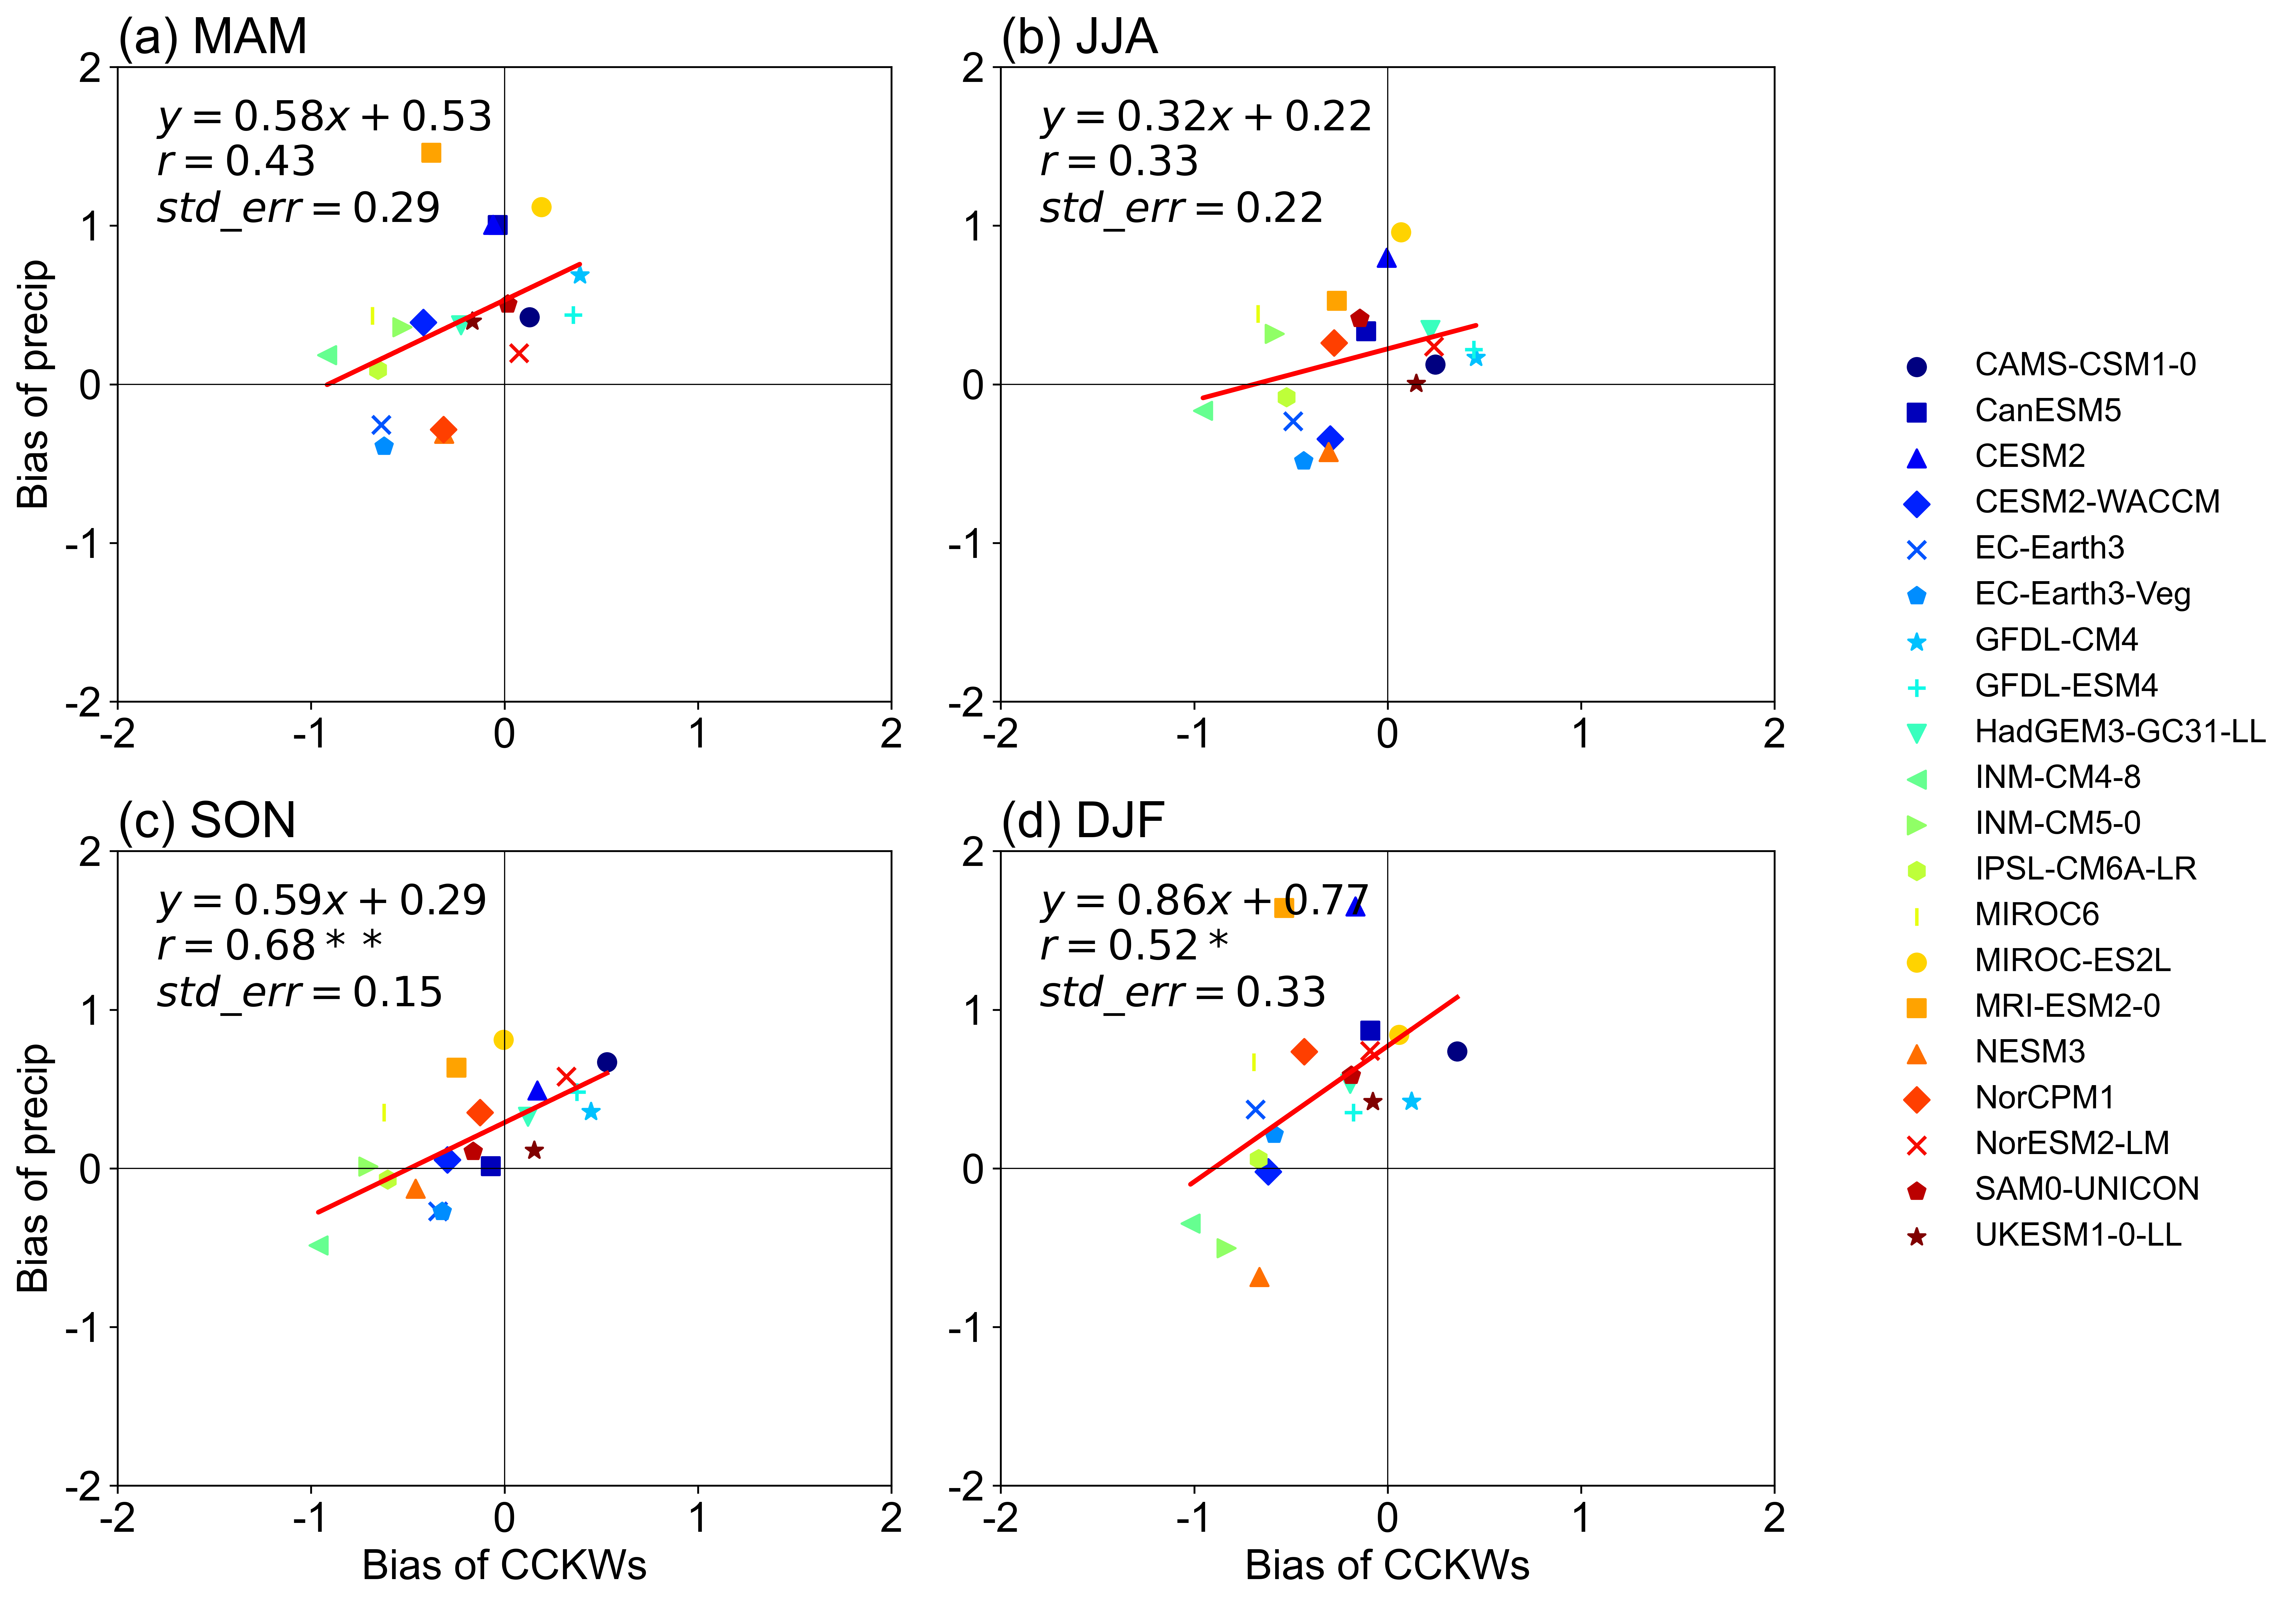

Folder k:\2024\2024-JGR-A-CMIP6_kelvin\CCKWs_ipynb_2025 already exists.
Figure saved at: k:\2024\2024-JGR-A-CMIP6_kelvin\CCKWs_ipynb_2025\fig12.pdf


In [9]:

var ='precipitation'
 
seasons = ['MAM', 'JJA', 'SON', 'DJF']
markers = ['o', 's', '^', 'D', 'x', 'p', '*', '+', 'v', '<', '>', 'h', '|']
colors = plt.cm.jet(np.linspace(0, 1, len(model_names)))
marker_styles = [m for m in markers]   
    
config = {
    "font.family": "Arial",
    "font.serif": ["Arial"],  # 全局默认使用衬线宋体
    "font.size": 18,  # 五号，10.5磅
    "axes.unicode_minus": False,
}
plt.rcParams.update(config)
subtitles=['(a)','(b)','(c)','(d)',]

fig, axs = plt.subplots(2, 2, figsize=(14, 10), dpi=600)
axs = axs.flatten()

for idx, season in enumerate(seasons):
    x, y = get_xy(xx ,yy, idx)  # 替换 None 为实际参数
    x_normalized = x
    y_normalized = y

    # x_normalized = (x - np.nanmean(x)) / np.nanstd(x)
    # y_normalized = (y - np.nanmean(y)) / np.nanstd(y)

    for i, model in enumerate(model_names):
        marker_style = markers[i % len(markers)]
        axs[idx].scatter(x_normalized[i], y_normalized[i],
                         marker=marker_style,
                         color=colors[i],
                         label=model,
                         s=60)
        
    # Compute and plot regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_normalized, y_normalized)
    print( slope, intercept, r_value, p_value, std_err)
    res = stats.linregress(x_normalized, y_normalized)
    from scipy.stats import t
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, len(x)-2)
    print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")
    
    
    print(f'{season} - T-statistic:  P-value: {p_value}')
    if p_value < 0.05:
        significance = "*"
        print(" 差异显著")
        if p_value < 0.01:
            significance = "**"
            print("very 差异显著")
    else:
        significance = ""
        print('not significant')

    reg_line = slope * x_normalized + intercept
    axs[idx].plot(x_normalized, reg_line, color='red', linestyle='-', linewidth=2)
    
    
    if idx in [3,4]:  # Bottom row
        axs[idx].set_xlabel('Normalized bias of CCKWs', )

    if idx in [0, 3]:  # Left column
        axs[idx].set_ylabel('Normalized bias of precip',)
    axs[idx].set_title(f'{subtitles[idx]} {season}',loc='left')
    # axs[idx].set_title(f'{season}')
    axs[idx].axhline(0, color='black', linewidth=0.5)
    axs[idx].axvline(0, color='black', linewidth=0.5)
    axs[idx].set_xlim((-2, 2))
    axs[idx].set_ylim((-2, 2))
    axs[idx].set_xlabel('Bias of CCKWs')
    axs[idx].set_ylabel('Bias of precip')
    if intercept>0:
        
        axs[idx].text(0.05, 0.95, f'$y = {slope:.2f}x + {intercept:.2f}$\n'
                                 f'$r = {r_value:.2f}{significance}$\n'
                                 f'$std\_err = {std_err:.2f}$',
                     transform=axs[idx].transAxes, fontsize=18,
                     verticalalignment='top')
    else:
        axs[idx].text(0.05, 0.95, f'$y = {slope:.2f}x  {intercept:.2f}$\n'
                                 f'$r = {r_value:.2f}{significance}$\n'
                                 f'$std\_err = {std_err:.2f}$',
                     transform=axs[idx].transAxes, fontsize=18,
                     verticalalignment='top')
    axs[idx].legend(ncol=2, frameon=False, bbox_to_anchor=(1.1, 0.8))
for ax in axs:
    ax.legend().remove()
    axs[3].set_ylabel('')
    axs[0].set_xlabel('')
    axs[1].set_xlabel('')
    axs[1].set_ylabel('')
# Add a single legend on the right
fig.legend(labels=model_names, loc='center right', 
           # bbox_to_anchor=(1.1, 0.8)
           ncol=1, frameon=False,fontsize="14")

plt.tight_layout(rect=[0, 0, 0.8, 1])  
plt.show()

save_figure(fig,'fig12')
    

## Fig.13-降水占比fraction分布图

同样，正确运行的代码在服务器上，这里只是整理代码内容，数据存在服务器上：
"/Users/xpji/code_v3_CCKWs/Pr_Prc_fraction.ipynb"

### 数据读取

In [ ]:
# def get_scatter_point(modelnames):
        
#     prc_path = '/Datadisk/CMIP6_daily2/prc/prc_interp_2x2/'
#     pr_path  = '/Datadisk/CMIP6_daily2/prc/pr_interp_2x2/'


#     prc_files = glob.glob(prc_path + 'prc_*.nc')
#     pr_files  = glob.glob(pr_path + 'pr*.nc')
#     prc_files.sort()
#     pr_files.sort()

#     print(len(prc_files),len(pr_files))

#     print(prc_files,'\n',pr_files,)
#     da_= {}
#     cc_path = r"/Datadisk/CMIP6_daily2/prc/CC_results.npy"
#     cc_data = np.load(cc_path,allow_pickle=True).item()
#     print(len(cc_data),cc_data)

#     for idx,prc_file in enumerate(prc_files):
#         pr_file = pr_files[idx]
#         prc_file = prc_files[idx]
#         model_name = prc_files[idx].split('/')[-1].split('_')[2]
#         if model_name  in modelnames:
#             print(model_name,'yes')
#             print(prc_file,'\n',pr_file)

#             prc = (xr.open_dataset(prc_file).sel(lat=slice(-10,10)).prc*86400).mean().values
#             pr  = (xr.open_dataset(pr_file).sel(lat=slice(-10,10)).pr*86400).mean().values

#             frac = prc/pr
#             da_[model_name] = {'corr':cc_data[model_name]['correlation'],
#                             'frac':frac,} 
            
#             print(cc_data[model_name]['correlation'],frac)
            
#         else:
#             pass
#             print(model_name,'no')
#     return da_

# modelnames1 = [

#     'CAMS-CSM1-0', 
#     'CESM2-WACCM', 
#     'CESM2', 
#     'CanESM5', 
#     'EC-Earth3-Veg',
#     'EC-Earth3', 
#     'GFDL-CM4', 
#     'GFDL-ESM4', 
#     'HadGEM3-GC31-LL',
#     'INM-CM4-8', 
#     'INM-CM5-0', 
#     'IPSL-CM6A-LR', 
#     'MIROC-ES2L',
#     'MIROC6', 
#     'MRI-ESM2-0', 
#     'NESM3', 
#     'NorCPM1', 
#     'NorESM2-LM', 
#     'SAM0-UNICON',
#     'UKESM1-0-LL']
# da_all = get_scatter_point(modelnames1)

# modelnames2 =  [

#     'CAMS-CSM1-0', 
#     'CESM2-WACCM', 
#     'CESM2', 
#     'CanESM5', 
#     'EC-Earth3-Veg',
#     'EC-Earth3', 
#     # 'GFDL-CM4', 
#     'GFDL-ESM4', 
#     'HadGEM3-GC31-LL',
#     # 'INM-CM4-8', 
#     # 'INM-CM5-0', 
#     # 'IPSL-CM6A-LR', 
#     'MIROC-ES2L',
#     'MIROC6', 
#     'MRI-ESM2-0', 
#     'NESM3', 
#     'NorCPM1', 
#     'NorESM2-LM', 
#     'SAM0-UNICON',
#     'UKESM1-0-LL']

# da_good = get_scatter_point(modelnames2)

In [ ]:

# modelnames1 = [

#     'CAMS-CSM1-0', 
#     'CESM2-WACCM', 
#     'CESM2', 
#     'CanESM5', 
#     'EC-Earth3-Veg',
#     'EC-Earth3', 
#     'GFDL-CM4', 
#     'GFDL-ESM4', 
#     'HadGEM3-GC31-LL',
#     'INM-CM4-8', 
#     'INM-CM5-0', 
#     'IPSL-CM6A-LR', 
#     'MIROC-ES2L',
#     'MIROC6', 
#     'MRI-ESM2-0', 
#     'NESM3', 
#     'NorCPM1', 
#     'NorESM2-LM', 
#     'SAM0-UNICON',
#     'UKESM1-0-LL']

# da_all = get_scatter_point(modelnames1)

# modelnames2 =  [

#     'CAMS-CSM1-0', 
#     'CESM2-WACCM', 
#     'CESM2', 
#     'CanESM5', 
#     'EC-Earth3-Veg',
#     'EC-Earth3', 
#     'GFDL-CM4', 
#     'GFDL-ESM4', 
#     'HadGEM3-GC31-LL',
#     # 'INM-CM4-8', 
#     # 'INM-CM5-0', 
#     # 'IPSL-CM6A-LR', 
#     'MIROC-ES2L',
#     'MIROC6', 
#     'MRI-ESM2-0', 
#     'NESM3', 
#     'NorCPM1', 
#     'NorESM2-LM', 
#     'SAM0-UNICON',
#     'UKESM1-0-LL']

# da_good = get_scatter_point(modelnames2)

# model_dict = {model: idx + 1 for idx, model in enumerate(modelnames1)}

# # 根据第二个列表去除缺失的模型并保持编号一致
# model_dict_filtered = {model: model_dict[model] for model in modelnames2}

# # 打印编号后的字典
# print("编号前的模型：")
# print(model_dict)
# # 打印编号后的字典
# print("编号后的模型：")
# print(model_dict_filtered)




FileNotFoundError: [Errno 2] No such file or directory: './data/saved_data.pkl'

In [3]:
with open("data\Fig13_saved_data.pkl", "rb") as f:
    data = pickle.load(f)

da_all = data["da_all"]
da_good = data["da_good"]
model_dict_filtered = data["model_dict_filtered"]

0 CAMS-CSM1-0
1 CESM2-WACCM
2 CESM2
3 CanESM5
4 EC-Earth3-Veg
5 EC-Earth3
6 GFDL-CM4
7 GFDL-ESM4
8 HadGEM3-GC31-LL
9 MIROC-ES2L
10 MIROC6
11 MRI-ESM2-0
12 NESM3
13 NorESM2-LM
14 SAM0-UNICON
15 UKESM1-0-LL
斜率: 0.3314 截距: 0.4001 R值: 0.4845 p值: 0.0572 标准误差: 0.1600
Pearson相关系数: 0.4845 p值: 0.0572


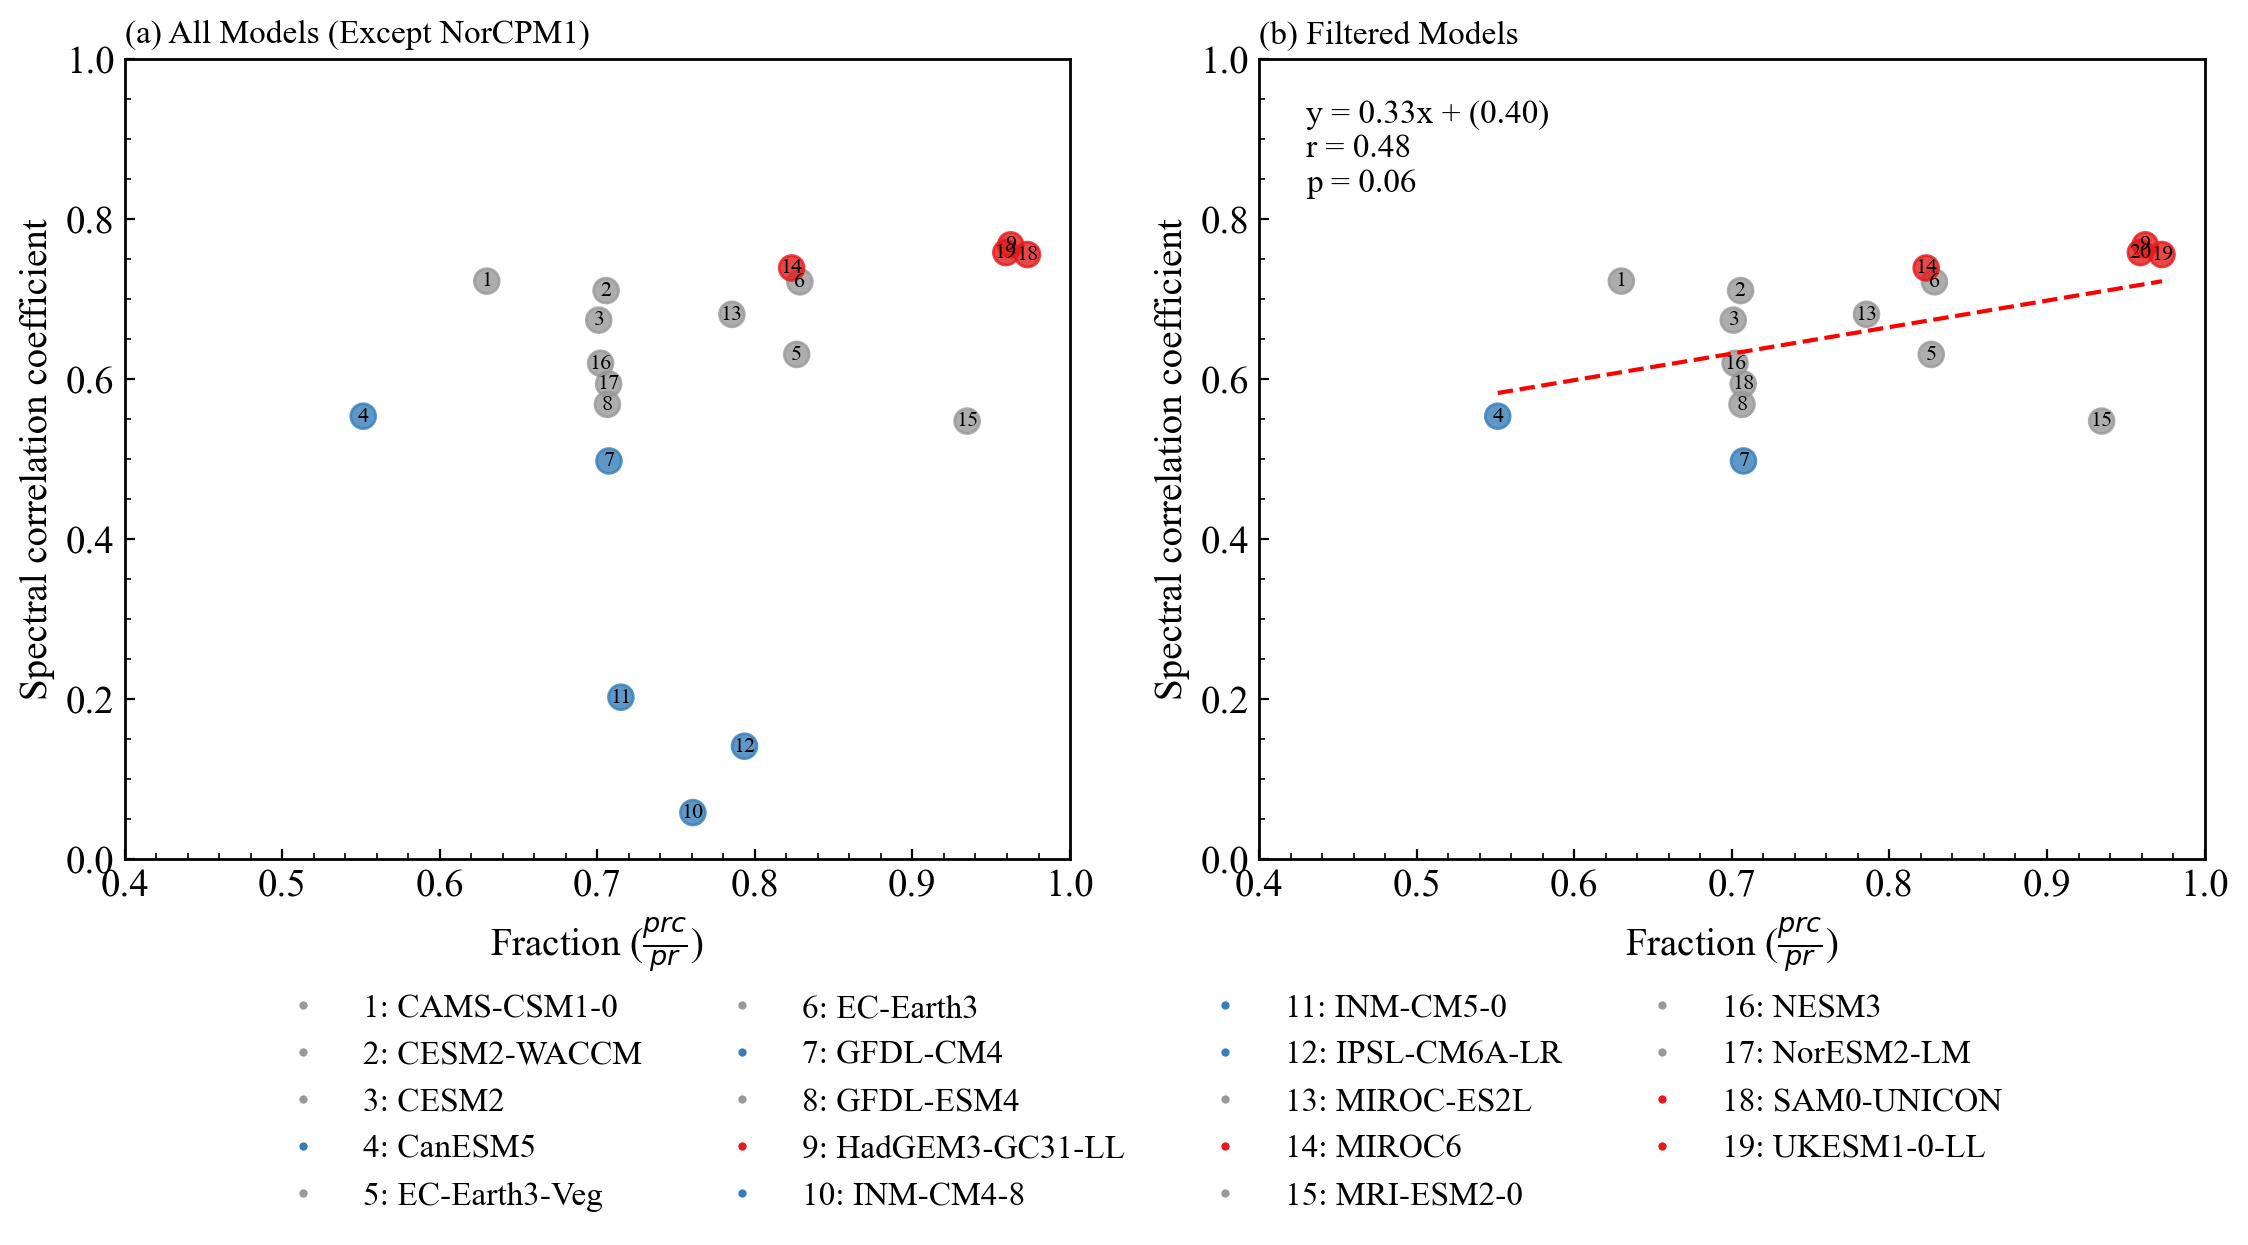

Folder k:\2024\2024-JGR-A-CMIP6_kelvin\CCKWs_ipynb_2025 already exists.
Figure saved at: k:\2024\2024-JGR-A-CMIP6_kelvin\CCKWs_ipynb_2025\fig13.pdf


In [6]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1
plt.rcParams['font.family'] =  'times new roman'


good_model_name  = ['UKESM1-0-LL','SAM0-UNICON','HadGEM3-GC31-LL',
                        'MIROC6','NorCPM1']

poor_model_name  = ['CanESM5','INM-CM5-0',
                        'IPSL-CM6A-LR','GFDL-CM4','INM-CM4-8']

def get_scatter_array(da):

        
    corr_values_1 = [da[key]['corr'] for key in da]
    frac_values_1 = [da[key]['frac'] for key in da]
    model_name = da.keys()
    corr_array_1 = np.array(corr_values_1)
    frac_array_1 = np.array(frac_values_1)

    return corr_array_1,frac_array_1,model_name

corr_array_all,frac_array_all,model_name_all = get_scatter_array(da_all)
corr_array_good,frac_array_good,model_name_good = get_scatter_array(da_good)



def get_scatter_color(model_name_all):

    colors_all = []
    for model in model_name_all:
        if model in good_model_name:
            colors_all.append('#e41a1c')
        elif model in poor_model_name:
            colors_all.append('#377eb8')
        else:
            colors_all.append('#999999')
    return colors_all


colors_all = get_scatter_color(model_name_all)

colors_good_all = get_scatter_color(model_name_good)

# 为了传递给sns.scatterplot的`hue`，我们可以通过颜色字典生成一个颜色列表

# 绘制散点图
colors_good_only = ['red' for _ in corr_array_good]  # 所有好的模型用红色
#=======================================================================================================================================================

# 创建绘图
fig = plt.figure(figsize=(13, 5))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# 第一部分：绘制所有模型的散点图，好的模型为红色，坏的模型为蓝色，其他模型为灰色
plt.subplot(121)
scatter = plt.scatter(frac_array_all, corr_array_all, c=colors_all, s=80, alpha=0.8,marker='o')
plt.ylabel('Spectral correlation coefficient')
plt.xlabel(r'Fraction ($\frac{prc}{pr}$)')
plt.ylim(0., 1)
plt.xlim(0.4, 1)

for i, model in enumerate(model_name_all):
    plt.text( frac_array_all[i], corr_array_all[i],f'{i+1}', color='black', ha='center', va='center', fontsize=8)

handles = []
for i, (model, color) in enumerate(zip(model_name_all, colors_all)):
    label = f'{i+1}: {model}'  # 在标签中显示序号和模型名称
    handles.append(mlines.Line2D([], [], marker='o', color='w', markerfacecolor=color, markersize=4, label=label))


plt.title("(a) All Models (Except NorCPM1)", loc='left', fontdict={'fontsize': 12})

# 第二部分：绘制好的模型的散点图
plt.subplot(122)
scatter_good = plt.scatter( frac_array_good,corr_array_good, c=colors_good_all, s=80, alpha=0.8)
plt.ylabel('Spectral correlation coefficient')
plt.xlabel(r'Fraction ($\frac{prc}{pr}$)')
plt.ylim(0., 1)
plt.xlim(0.4, 1)

for i, model in enumerate(model_name_good):
    print(i, model)
    plt.text( frac_array_good[i], corr_array_good[i],f'{model_dict_filtered[model]}', color='black', ha='center', va='center', fontsize=8)

plt.title("(b) Filtered Models", loc='left', fontdict={'fontsize': 12})

# # 计算线性拟合的参数 (slope, intercept) 及其显著性
plt.legend(handles=handles, title='', loc='upper center', bbox_to_anchor=(-.13, -0.13), ncol=4, frameon=False,fontsize=12)
slope, intercept, r_value, p_value, std_err = stats.linregress( frac_array_good,corr_array_good)
print(f"斜率: {slope:.4f}", f"截距: {intercept:.4f}", f"R值: {r_value:.4f}", f"p值: {p_value:.4f}", f"标准误差: {std_err:.4f}")
# # 计算并绘制线性趋势线

x_vals = np.linspace(frac_array_good.min(), frac_array_good.max(), 1000)
y_vals = intercept + slope * x_vals
plt.plot(x_vals,y_vals,  color='red', linestyle='--', linewidth=1.5)

# # # 进行Pearson相关性检验
corr_coeff, p_value_pearson = stats.pearsonr(frac_array_good,corr_array_good)
print(f"Pearson相关系数: {corr_coeff:.4f}", f"p值: {p_value_pearson:.4f}")
# # # 显示相关系数、线性方程和显著性检验结果
if p_value_pearson < 0.01:
    significance = '**'
elif p_value_pearson < 0.05:
    significance = '*'
else:
    significance = ''

# # # 根据显著性显示拟合表达式和相关系数
equation = f'y = {slope:.2f}x + ({intercept:.2f})'
corr_text = f'r = {r_value:.2f}'
p_text = f'p = {p_value:.2f}'
# display(Math(f'${equation}$'))
# display(Math(f'${corr_text}$'))
# display(Math(f'${p_text}$'))
# # # 显示线性拟合方程和相关系数
plt.text(0.05, 0.95, f'{equation}\n{corr_text}\n{p_text}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', color='black')

# plt.tight_layout()  # 调整布局以避免图例遮挡
plt.show()
save_figure(fig,'fig13')
#=======================================================================================================================================================

